## Pruebas

In [1]:
%pylab inline

import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import seaborn as sns

Populating the interactive namespace from numpy and matplotlib


In [2]:
#products = pd.read_csv('products_clean.csv')
#sales = pd.read_csv('sales_clean.csv')
#stock = pd.read_csv('stock_clean.csv')
sales_prod = pd.read_csv('sp_clean.csv')
#stock_prod = pd.read_csv('stp_clean.csv')
#groupby_sales = pd.read_csv('gb_sales_clean.csv')
#subcategories_list = pd.read_csv('subc_list_clean.csv')
#materials_list = pd.read_csv('mat_list_clean.csv')

## MODELOS ML

In [5]:
import time

import matplotlib as mpl
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
#import plotly.graph_objects as go
import seaborn as sns


from datetime import datetime
from sklearn import linear_model
from sklearn.model_selection import GridSearchCV

In [6]:
pd.set_option('display.max_columns', None)
sales_prod.head(1)

,Unnamed: 0,ID,NRO_DOCUMENTO,FECHA,CODIGO_TIENDA,TIENDA,PROD_REF,CANTIDAD,PRECIO,SUBTOTAL,DESCUENTO(%),TOTAL,ANIO,MES,DIA,ITEM,REF,DESCRIPCION,CATEGORIA,SUBCATEGORIA,VIGENCIA,ORIGEN,ESTILO,MATERIAL,ACABADO,PUESTOS,COLOR,ANCHO,ALTO,FONDO,DESC_LARGA,SUBCATEGORIA_POS,COLOR_POS,MATERIAL_POS
0,0,11:FSV-00001071:XZ0862:00005:,FSV-00001071,2019-01-17,11,ADMINISTRACION,XZ0862:00005:,1,188922.0,188922,0.599999,75569,2019,1,3,6084,XZ0862:00005:,MESA AUX LAUREL,SALAS Y SOFAS,MESAS AUXILIARES,LINEA,IMPORTADO,CONTEMPORÁNEO,MADERA+VIDRIO,MATE,NaN,NEGRO,40.0,45.0,40.0,MESA AUXILIAR LAUREL 39X40X50 CRISTAL NG,OTROS,NEGRO,OTRO


In [7]:
sales_prod['AREA']=sales_prod['ANCHO']*sales_prod['FONDO']

In [8]:
sales_prod['PUESTOS'].fillna(0,inplace=True)

In [9]:

columns_HD = ['REF','TIENDA', 'PRECIO', 'SUBTOTAL','DESCUENTO(%)','TOTAL','CANTIDAD','ANIO','MES','CATEGORIA','SUBCATEGORIA','VIGENCIA','ORIGEN','ESTILO','MATERIAL','ACABADO','COLOR','ALTO','AREA','PUESTOS']
columns_LD= ['REF','TIENDA', 'PRECIO', 'SUBTOTAL','DESCUENTO(%)','TOTAL','CANTIDAD','ANIO','MES','CATEGORIA','SUBCATEGORIA_POS','VIGENCIA','ORIGEN','ESTILO','MATERIAL_POS','ACABADO','COLOR_POS','ALTO','AREA','PUESTOS']

In [10]:
sales_prod_HD=sales_prod[columns_HD]
sales_prod_LD=sales_prod[columns_LD]

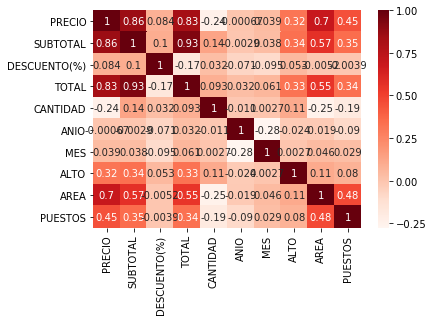

In [11]:
sns.heatmap(sales_prod_HD.corr(),cmap='Reds',annot=True)

sacar precio afuera?

**Solo por producto**

In [12]:
sales_ref_month=sales_prod_LD.groupby(['ANIO','MES','REF','TIENDA']).agg({'PRECIO':'mean','SUBTOTAL':'sum','DESCUENTO(%)':'mean','TOTAL':'sum','CANTIDAD':'sum','ALTO':'first','AREA':'first','PUESTOS':'first','COLOR_POS':'first','CATEGORIA':'first','SUBCATEGORIA_POS':'first','VIGENCIA':'first','ORIGEN':'first','ESTILO':'first','MATERIAL_POS':'first','ACABADO':'first'}).reset_index().sort_values(by=['ANIO','MES'])

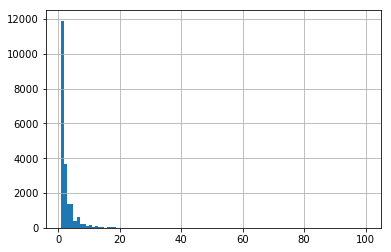

In [13]:
sales_ref_month.CANTIDAD.hist(bins=100)

In [14]:
sales_ref_month.CANTIDAD.quantile(0.99)

16.0

In [15]:
covid=sales_ref_month[['ANIO','MES']].drop_duplicates().reset_index(drop=True)
aux2=[0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,3,1,1,1,2,2,1,1,2,2,1,1,1]

In [16]:
covid['Factor covid']=aux2


In [17]:
sales_ref_month=sales_ref_month.merge(covid,on=['ANIO','MES'])

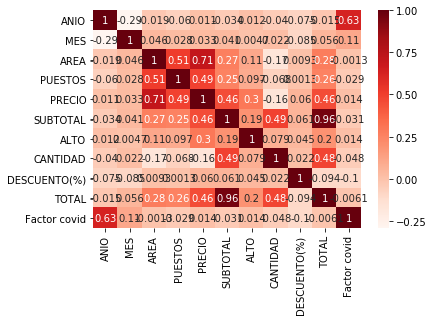

In [18]:
sns.heatmap(sales_ref_month.corr(),cmap='Reds',annot=True)

In [19]:
def remove_ventas_anormales(df):
    return df.query('CANTIDAD<20')

In [20]:
sales_ref_month2=remove_ventas_anormales(sales_ref_month).reset_index(drop=True)

In [21]:
num_var=['AREA','ALTO','DESCUENTO(%)','PRECIO','CANTIDAD',]
cat_var=['MES','Factor covid','PUESTOS','COLOR_POS','CATEGORIA','SUBCATEGORIA_POS','VIGENCIA','ORIGEN','ESTILO','MATERIAL_POS','ACABADO','TIENDA']

In [22]:
y=sales_ref_month2['CANTIDAD']

In [23]:
X_num=sales_ref_month2[num_var[:-1]].astype('float')
X_cat=sales_ref_month2[cat_var].astype('category')

In [24]:
X_cat_dummies=pd.get_dummies(X_cat)

In [25]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

In [26]:
scaler=StandardScaler()
X_num_norm= scaler.fit_transform(X_num)
scaler2=StandardScaler()
y_norm=scaler2.fit_transform(y.values.reshape(-1,1))


C:\Users\Johan\anaconda3\envs\py35\lib\site-packages\sklearn\utils\validation.py:590: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\Johan\anaconda3\envs\py35\lib\site-packages\sklearn\utils\validation.py:590: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [27]:
X=np.append(X_num_norm,X_cat_dummies,axis=1)

In [28]:
#split data till march 2021
index=sales_ref_month2[(sales_ref_month2.ANIO==2021)].index[0]
X_train=X[:index]
y_train=y[:index]
X_test=X[index:]
y_test=y[index:]


In [29]:
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error as mse

In [30]:
mod = sm.OLS(y_train, sm.add_constant(X_train))
res = mod.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               CANTIDAD   R-squared:                       0.260
Model:                            OLS   Adj. R-squared:                  0.256
Method:                 Least Squares   F-statistic:                     74.04
Date:                Thu, 02 Sep 2021   Prob (F-statistic):               0.00
Time:                        12:39:05   Log-Likelihood:                -37289.
No. Observations:               17610   AIC:                         7.475e+04
Df Residuals:                   17526   BIC:                         7.540e+04
Df Model:                          83                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       4.584e+11   1.29e+12      0.357      0.721   -2.06e+12    2.98e+12
x1             0.0334      0.037      0.895      0.371      -0.040       0.106
x2             0.0465      0.025      1.886      0.059      -0.002       0.095
x3             0.1780      0.017     10.360      0.000       0.144       0.212
x4            -0.2616      0.038     -6.903      0.000      -0.336      -0.187
x5         -7.666e+10   2.15e+11     -0.357      0.721   -4.98e+11    3.45e+11
x6         -7.666e+10   2.15e+11     -0.357      0.721   -4.98e+11    3.45e+11
x7         -7.666e+10   2.15e+11     -0.357      0.721   -4.98e+11    3.45e+11
x8         -7.666e+10   2.15e+11     -0.357      0.721   -4.98e+11    3.45e+11
x9         -7.666e+10   2.15e+11     -0.357      0.721   -4.98e+11    3.45e+11
x10        -7.666e+10   2.15e+11     -0.357      0.721   -4.98e+11    3.45e+11
x11        -7.666e+10   2.15e+11     -0.357      0.721   -4.98e+11    3.45e+11
x12        -7.666e+10   2.15e+11     -0.357      0.721   -4.98e+11    3.45e+11
x13        -7.666e+10   2.15e+11     -0.357      0.721   -4.98e+11    3.45e+11
x14        -7.666e+10   2.15e+11     -0.357      0.721   -4.98e+11    3.45e+11
x15        -7.666e+10   2.15e+11     -0.357      0.721   -4.98e+11    3.45e+11
x16        -7.666e+10   2.15e+11     -0.357      0.721   -4.98e+11    3.45e+11
x17         -7.36e+11   2.06e+12     -0.357      0.721   -4.78e+12    3.31e+12
x18         -7.36e+11   2.06e+12     -0.357      0.721   -4.78e+12    3.31e+12
x19         -7.36e+11   2.06e+12     -0.357      0.721   -4.78e+12    3.31e+12
x20         -7.36e+11   2.06e+12     -0.357      0.721   -4.78e+12    3.31e+12
x21          1.32e+11    3.7e+11      0.357      0.721   -5.94e+11    8.58e+11
x22          1.32e+11    3.7e+11      0.357      0.721   -5.94e+11    8.58e+11
x23          1.32e+11    3.7e+11      0.357      0.721   -5.94e+11    8.58e+11
x24          1.32e+11    3.7e+11      0.357      0.721   -5.94e+11    8.58e+11
x25          1.32e+11    3.7e+11      0.357      0.721   -5.94e+11    8.58e+11
x26          1.32e+11    3.7e+11      0.357      0.721   -5.94e+11    8.58e+11
x27          1.32e+11    3.7e+11      0.357      0.721   -5.94e+11    8.58e+11
x28          6.02e+10   1.69e+11      0.357      0.721   -2.71e+11    3.91e+11
x29          6.02e+10   1.69e+11      0.357      0.721   -2.71e+11    3.91e+11
x30          6.02e+10   1.69e+11      0.357      0.721   -2.71e+11    3.91e+11
x31          6.02e+10   1.69e+11      0.357      0.721   -2.71e+11    3.91e+11
x32          6.02e+10   1.69e+11      0.357      0.721   -2.71e+11    3.91e+11
x33          6.02e+10   1.69e+11      0.357      0.721   -2.71e+11    3.91e+11
x34          6.02e+10   1.69e+11      0.357      0.721   -2.71e+11    3.91e+11
x35          6.02e+10   1.69e+11      0.357      0.721   -2.71e+11    3.91e+11
x3

In [29]:
y_predicted=res.predict(sm.add_constant(X_test,has_constant='add'))
mse(y_test,y_predicted)

2.7948335297657434

In [32]:
traint=sales_ref_month2[:index]
traint['predicted']=(res.predict(sm.add_constant(X_train,has_constant='add')))

In [33]:
traint.query('(REF=="D00935:00048:00048")& TIENDA=="PUNTO DE VENTA AV 68" ')

,ANIO,MES,REF,TIENDA,TOTAL,SUBCATEGORIA_POS,CANTIDAD,DESCUENTO(%),ALTO,ORIGEN,VIGENCIA,PRECIO,COLOR_POS,AREA,ACABADO,MATERIAL_POS,CATEGORIA,SUBTOTAL,PUESTOS,ESTILO,Factor covid,predicted
646,2019,2,D00935:00048:00048,PUNTO DE VENTA AV 68,268900,SOFA CAMA ABATIBLE,1,0.487180,82.0,MANUFACTURADO,LINEA,524356.000000,AZUL,16744.0,TEXTILES SUAVES,MICROFIBRA,SALAS Y SOFAS,524356,3.0,MODERNO,0,2.361938
1227,2019,3,D00935:00048:00048,PUNTO DE VENTA AV 68,268900,SOFA CAMA ABATIBLE,1,0.487180,82.0,MANUFACTURADO,LINEA,524356.000000,AZUL,16744.0,TEXTILES SUAVES,MICROFIBRA,SALAS Y SOFAS,524356,3.0,MODERNO,0,2.192383
2057,2019,4,D00935:00048:00048,PUNTO DE VENTA AV 68,804705,SOFA CAMA ABATIBLE,3,0.500000,82.0,MANUFACTURADO,LINEA,536470.000000,AZUL,16744.0,TEXTILES SUAVES,MICROFIBRA,SALAS Y SOFAS,1609410,3.0,MODERNO,0,2.127686
2728,2019,5,D00935:00048:00048,PUNTO DE VENTA AV 68,1341175,SOFA CAMA ABATIBLE,5,0.500000,82.0,MANUFACTURADO,LINEA,536470.125000,AZUL,16744.0,TEXTILES SUAVES,MICROFIBRA,SALAS Y SOFAS,2682351,3.0,MODERNO,0,2.476685
3514,2019,6,D00935:00048:00048,PUNTO DE VENTA AV 68,1341177,SOFA CAMA ABATIBLE,5,0.500000,82.0,MANUFACTURADO,LINEA,536470.375000,AZUL,16744.0,TEXTILES SUAVES,MICROFIBRA,SALAS Y SOFAS,2682353,3.0,MODERNO,0,2.643188
4270,2019,7,D00935:00048:00048,PUNTO DE VENTA AV 68,1877646,SOFA CAMA ABATIBLE,7,0.500000,82.0,MANUFACTURADO,LINEA,536470.291667,AZUL,16744.0,TEXTILES SUAVES,MICROFIBRA,SALAS Y SOFAS,3755293,3.0,MODERNO,0,2.592163
5103,2019,8,D00935:00048:00048,PUNTO DE VENTA AV 68,536470,SOFA CAMA ABATIBLE,2,0.500000,82.0,MANUFACTURADO,LINEA,536470.000000,AZUL,16744.0,TEXTILES SUAVES,MICROFIBRA,SALAS Y SOFAS,1072940,3.0,MODERNO,0,2.327759
5850,2019,9,D00935:00048:00048,PUNTO DE VENTA AV 68,771092,SOFA CAMA ABATIBLE,3,0.520885,82.0,MANUFACTURADO,LINEA,536470.000000,AZUL,16744.0,TEXTILES SUAVES,MICROFIBRA,SALAS Y SOFAS,1609410,3.0,MODERNO,0,2.589844
6634,2019,10,D00935:00048:00048,PUNTO DE VENTA AV 68,536470,SOFA CAMA ABATIBLE,2,0.500000,82.0,MANUFACTURADO,LINEA,536470.000000,AZUL,16744.0,TEXTILES SUAVES,MICROFIBRA,SALAS Y SOFAS,1072940,3.0,MODERNO,0,2.401611
7473,2019,11,D00935:00048:00048,PUNTO DE VENTA AV 68,536470,SOFA CAMA ABATIBLE,2,0.500000,82.0,MANUFACTURADO,LINEA,536470.000000,AZUL,16744.0,TEXTILES SUAVES,MICROFIBRA,SALAS Y SOFAS,1072940,3.0,MODERNO,0,2.752319


(0, 600)

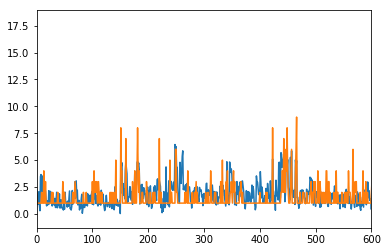

In [34]:
plt.plot(range(len(y_predicted)),y_predicted)
plt.plot(range(len(y_predicted)),y_test)
plt.xlim(0,600)


In [76]:
from sklearn.ensemble import GradientBoostingRegressor

In [77]:
br=GradientBoostingRegressor(**{'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 300})

In [78]:
br.fit(X_train,y_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=2, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=300, n_iter_no_change=None, presort='auto',
             random_state=None, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False)

In [79]:
from sklearn.metrics import mean_squared_error as mse
mse(br.predict(X_test),y_test)

2.6795394303682962

In [37]:
t=sales_ref_month2[index:]
t['predicted']=br.predict(X_test)
t2=t.groupby(['REF','MES','ANIO']).agg({'predicted':'sum','CANTIDAD':'sum'}).reset_index()
t2

,REF,MES,ANIO,predicted,CANTIDAD
0,BR0002:00193:,1,2021,2.062525,2
1,BR0002:00193:,2,2021,2.466417,1
2,BR0002:00193:,4,2021,2.870442,3
3,BR0003:00194:,1,2021,1.448494,1
4,BR0003:00194:,2,2021,5.462023,5
5,BR0003:00194:,4,2021,3.789482,4
6,BR0005:00193:,1,2021,1.151385,1
7,BR0005:00193:,2,2021,6.693324,5
8,BR0005:00193:,3,2021,3.654106,2
9,BR0005:00193:,4,2021,1.109336,1


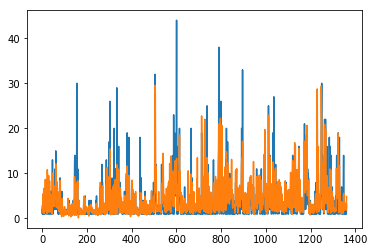

In [38]:
plt.plot(t2.CANTIDAD)
plt.plot(t2.predicted)

(0, 100)

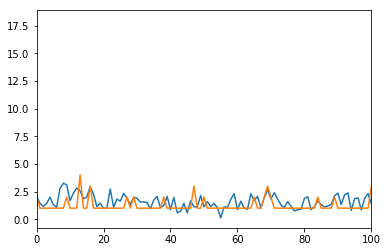

In [39]:
plt.plot(range(len(y_predicted)),br.predict(X_test))
plt.plot(range(len(y_predicted)),y_test)
plt.xlim(0,100)

In [38]:
from sklearn.metrics import r2_score as r2
r2(br.predict(X_test),y_test)

-9.955809213387369

In [34]:
list(zip(X_num.columns.append(X_cat_dummies.columns),br.feature_importances_))

[('AREA', 0.05574620585125613),
 ('ALTO', 0.033779026768740984),
 ('DESCUENTO(%)', 0.4777923230414482),
 ('PRECIO', 0.10944696549753398),
 ('MES_1', 0.014640925988445725),
 ('MES_2', 0.009049249125743269),
 ('MES_3', 0.001579097228123056),
 ('MES_4', 0.0023221175603797143),
 ('MES_5', 0.0029939640450905632),
 ('MES_6', 0.0008520993082224576),
 ('MES_7', 0.003004516549775797),
 ('MES_8', 0.0012079650601133324),
 ('MES_9', 0.000578760289888369),
 ('MES_10', 0.00406103909617418),
 ('MES_11', 0.0005238774607143171),
 ('MES_12', 0.00364194271066402),
 ('Factor covid_0', 0.007565933391367926),
 ('Factor covid_1', 0.0006147372927978665),
 ('Factor covid_2', 0.001118058710040306),
 ('Factor covid_3', 0.002616218010534017),
 ('PUESTOS_0.0', 0.006074706040840327),
 ('PUESTOS_1.0', 0.0005351144107219504),
 ('PUESTOS_2.0', 0.0),
 ('PUESTOS_3.0', 0.002214164031886986),
 ('PUESTOS_4.0', 0.0028969556341387876),
 ('PUESTOS_6.0', 0.0011810937295948143),
 ('PUESTOS_7.0', 0.0),
 ('COLOR_POS_AMARILLO', 0.

In [40]:
param_dist = {'n_estimators':[30, 40, 100, 200, 300],'learning_rate':[0.01, 0.05, 0.1, 0.3, 0.4, 1], 'max_depth': [2,4,6,8,10]}

In [41]:
grid_clf_br = GridSearchCV(GradientBoostingRegressor(), param_grid = param_dist,cv=3,n_jobs=4,scoring='neg_mean_squared_error')
grid_clf_br.fit(X_train, y_train)


KeyboardInterrupt: 

In [90]:
grid_clf_br.best_score_

-0.3676259697893915

In [91]:
grid_clf_br.best_params_

{'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 200}

In [97]:
import joblib
joblib.dump(grid_clf_br,'model_sin_out_tiendas.pkl')

['model_sin_out_tiendas.pkl']

In [101]:
loaded_model = joblib.load('model_sin_out_tiendas.pkl')
result = mse(loaded_model.predict(X_test), y_test)
result

0.36091235226845697

In [92]:
best={'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 200}

In [44]:
br2=GradientBoostingRegressor(**{'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 200})

br2.fit(X_train,y_train)

mse(br2.predict(X_test),y_test)

2.6804795636896235

In [93]:
mse(grid_clf_br.predict(X_test),y_test)

0.36091235226845697

In [102]:
mse(grid_clf_br.predict(X_train),y_train)

0.3345549220548181

In [43]:
y_predicted2=grid_clf_br.predict(X_test)

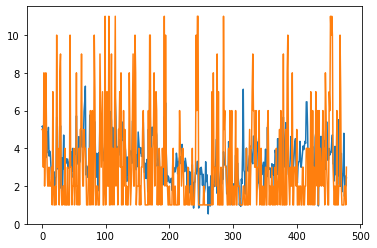

In [44]:
plt.figure()
plt.plot(range(len(y_predicted2)),(y_predicted2))
plt.plot(range(len(y_predicted2)),(y_test))

In [43]:
sales_train=sales_ref_month2[:index-1]
sales_test=sales_ref_month2[index:]
sales_train['predicted']=br2.predict(X_train)
sales_test['predicted']=br2.predict(X_test)
sales_test['fecha']= pd.to_datetime(sales_test['ANIO'].astype(str)+'/'+sales_test['MES'].astype(str))#,format="%Y/%M")
sales_train['fecha']= pd.to_datetime(sales_train['ANIO'].astype(str)+'/'+sales_train['MES'].astype(str))#,format="%Y/%M")

joint=pd.concat([sales_train,sales_test],axis=0)



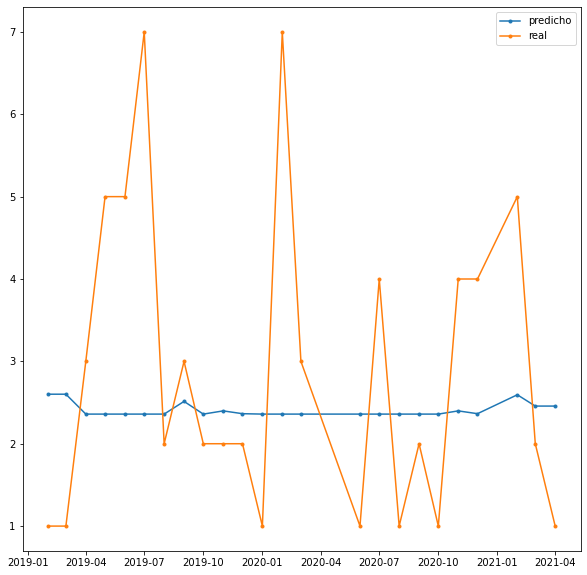

In [48]:
def plot_by_ref_tienda(ref,tienda):
    aux=joint.query('REF==@ref & TIENDA==@tienda')
    plt.figure(figsize=(10,10))
    plt.plot(aux['fecha'],aux['predicted'],label='predicho',marker='.')
    plt.plot(aux['fecha'],aux['CANTIDAD'],label='real',marker='.')
    plt.legend()
plot_by_ref_tienda('D00935:00048:00048','PUNTO DE VENTA AV 68')



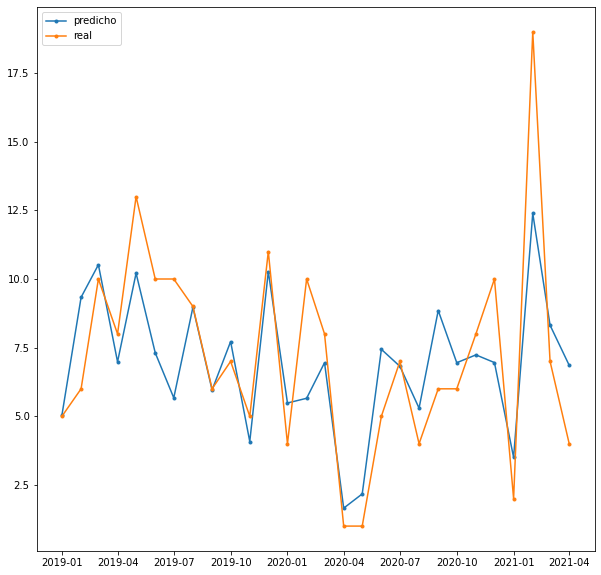

In [49]:
def plot_by_ref(ref):
    aux0=joint.groupby(['REF','ANIO','MES','fecha']).agg({'CANTIDAD':'sum','predicted':'sum'}).reset_index()
    aux=aux0.query('REF==@ref')
    plt.figure(figsize=(10,10))
    plt.plot(aux['fecha'],aux['predicted'],label='predicho',marker='.')
    plt.plot(aux['fecha'],aux['CANTIDAD'],label='real',marker='.')
    plt.legend()
plot_by_ref('D00935:00048:00048')

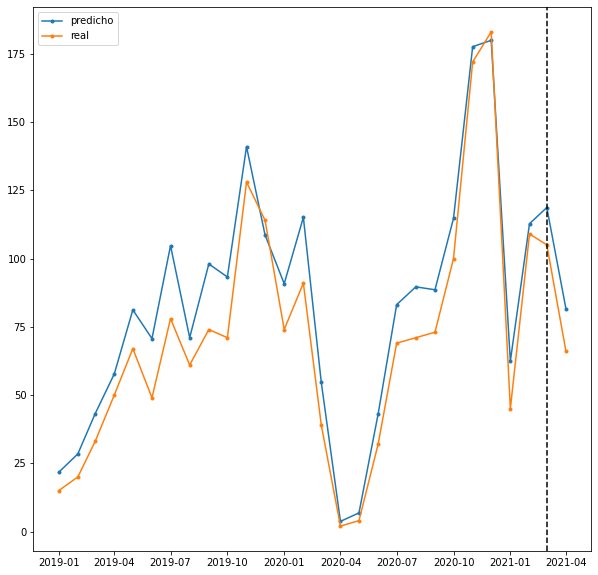

In [45]:
def plot_by_cat(subcat):
    aux0=joint.groupby(['SUBCATEGORIA_POS','ANIO','MES','fecha']).agg({'CANTIDAD':'sum','predicted':'sum'}).reset_index()
    aux=aux0.query('SUBCATEGORIA_POS==@subcat')
    #print(aux)
    plt.figure(figsize=(10,10))
    plt.plot(aux['fecha'],aux['predicted'],label='predicho',marker='.')
    plt.plot(aux['fecha'],aux['CANTIDAD'],label='real',marker='.')
    plt.axvline(x=pd.to_datetime('2021-03-01'),color='black',linestyle='--')
    plt.legend()
plot_by_cat('SOFA 2P')


In [181]:
l2.fecha

566     2019-01-01 00:02:00
1062    2019-01-01 00:03:00
1794    2019-01-01 00:04:00
4310    2019-01-01 00:08:00
4939    2019-01-01 00:09:00
5585    2019-01-01 00:10:00
6304    2019-01-01 00:11:00
7101    2019-01-01 00:12:00
7802    2020-01-01 00:01:00
9293    2020-01-01 00:03:00
9879    2020-01-01 00:06:00
10950   2020-01-01 00:08:00
11478   2020-01-01 00:09:00
12216   2020-01-01 00:10:00
Name: fecha, dtype: datetime64[ns]

In [172]:
l2=sales_train.query('REF=="D00935:00048:00048"& TIENDA=="PUNTO DE VENTA AV 68"')
l2.CANTIDAD

566      1
1062     1
1794     3
4310     2
4939     3
5585     2
6304     2
7101     2
7802     1
9293     3
9879     1
10950    1
11478    2
12216    1
Name: CANTIDAD, dtype: int64

In [207]:
sales_test['SUBCATEGORIA_POS'].value_counts()

OTROS                 458
SOFA 2P               115
SET 4P                101
SOFA 3P               100
SOFA CAMA ABATIBLE     78
MESAS DE CENTRO        68
SILLAS AUXILIARES      56
RECLINABLES            52
POLTRONAS              49
PUFF                   48
RECLINABLES 1P         41
SET 6P                 30
SILLAS DE COMEDOR      29
MESAS DE 4P            26
Name: SUBCATEGORIA_POS, dtype: int64

In [160]:
l2.CANTIDAD.value_counts()

1    53
2    26
3     8
Name: CANTIDAD, dtype: int64

In [141]:
sales_train.groupby(['REF','TIENDA','FECHA'])

,ANIO,MES,REF,TIENDA,PRECIO,SUBTOTAL,DESCUENTO(%),TOTAL,CANTIDAD,ALTO,AREA,PUESTOS,COLOR_POS,CATEGORIA,SUBCATEGORIA_POS,VIGENCIA,ORIGEN,ESTILO,MATERIAL_POS,ACABADO,Factor covid,predicted,fecha
15728,2021,3,BR0005:00193:,PUNTO DE VENTA AV 68,505512.0,505512,0.391049,307832,1,77.0,7800.0,0.0,OTRO,ESTUDIO,OTROS,NOVEDAD,IMPORTADO,CONTEMPORÁNEO,MADERA LAMINADA,MATE,1,2.0,2021-01-01 00:03:00
15729,2021,3,BR0005:00193:,PUNTO DE VENTA CALLE 134,505512.0,505512,0.391049,307832,1,77.0,7800.0,0.0,OTRO,ESTUDIO,OTROS,NOVEDAD,IMPORTADO,CONTEMPORÁNEO,MADERA LAMINADA,MATE,1,1.0,2021-01-01 00:03:00
15730,2021,3,BR0007:00195:,PUNTO DE VENTA AV 68,211616.0,211616,0.393543,128336,1,180.0,2541.0,0.0,OTRO,ESTUDIO,OTROS,NOVEDAD,IMPORTADO,CONTEMPORÁNEO,MADERA LAMINADA,MATE,1,2.0,2021-01-01 00:03:00
15731,2021,3,BR0007:00195:,PUNTO DE VENTA PLAZA CENTRAL,211616.0,211616,0.393543,128336,1,180.0,2541.0,0.0,OTRO,ESTUDIO,OTROS,NOVEDAD,IMPORTADO,CONTEMPORÁNEO,MADERA LAMINADA,MATE,1,1.0,2021-01-01 00:03:00
15732,2021,3,BR0008:00012:,PAGINA WEB FIOTTI,213405.0,213405,0.442726,118925,1,180.0,2541.0,0.0,OTRO,ESTUDIO,OTROS,NOVEDAD,IMPORTADO,CONTEMPORÁNEO,MADERA LAMINADA,MATE,1,1.0,2021-01-01 00:03:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16974,2021,4,XZ0897:00044:,PUNTO DE VENTA POBLADO,1088256.0,1088256,0.400000,652954,1,75.0,13500.0,6.0,OTRO,COMEDORES,OTROS,LINEA,IMPORTADO,MODERNO,VIDRIO,BRILLANTE,1,1.0,2021-01-01 00:04:00
16975,2021,4,XZ0914-1:00001:,PUNTO DE VENTA CALI,1984260.0,1984260,0.390870,1208672,1,75.0,8400.0,6.0,BLANCO,COMEDORES,SET 6P,LINEA,IMPORTADO,CLÁSICO,METAL + VIDRIO,MATE,1,1.0,2021-01-01 00:04:00
16976,2021,4,XZ0993:00100:,ADMINISTRACION,593462.0,593462,0.493755,300437,1,44.0,5000.0,0.0,BLANCO,SALAS Y SOFAS,MESAS DE CENTRO,DESCONTINUADO,IMPORTADO,CONTEMPORÁNEO,VIDRIO,BRILLANTE,1,1.0,2021-01-01 00:04:00
16977,2021,4,XZ0993:00100:,PUNTO DE VENTA AV 68,546678.0,546678,0.619999,207738,1,44.0,5000.0,0.0,BLANCO,SALAS Y SOFAS,MESAS DE CENTRO,DESCONTINUADO,IMPORTADO,CONTEMPORÁNEO,VIDRIO,BRILLANTE,1,1.0,2021-01-01 00:04:00


In [121]:
mse(sales_test.CANTIDAD,sales_test.predicted)

0.5019984012789768

In [ ]:
sales_test.groupby(['REF','TIENDA'])


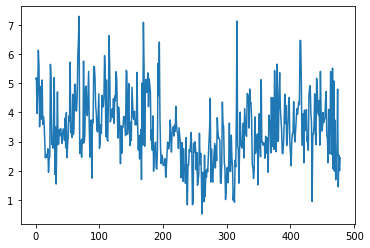

In [46]:
plt.plot(range(len(y_predicted2)),(y_predicted2))

In [ ]:
import sklearn

In [ ]:
sklearn.metrics.SCORERS.keys()

Lasso o Ridge?

In [47]:
from sklearn.linear_model import Ridge, Lasso

In [48]:
rr=Ridge(alpha=1000)
rr.fit(X_train,y_train)
mse(y_test,rr.predict(X_test))


6.1084118220422505

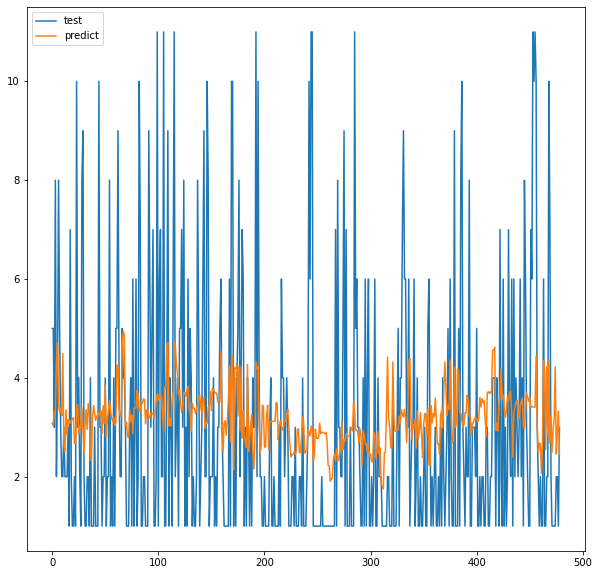

In [49]:
plt.figure(figsize=(10,10))
plt.plot(range(len(rr.predict(X_test))),y_test,label='test')
plt.plot(range(len(rr.predict(X_test))),rr.predict(X_test),label='predict')
plt.legend()

In [50]:
rr=Lasso(alpha=0.0555)
rr.fit(X_train,y_train)
mse(y_test,rr.predict(X_test))


6.203307208607622

again but scaling numerical features

In [134]:
from scipy import stats

In [135]:
X_num['DESCUENTO(%)']=X_num['DESCUENTO(%)']+0.00001
num_columns=['AREA','ALTO','DESCUENTO(%)','PRECIO'] #Descuento no se puede porque tiene 0
X_num_tran=pd.DataFrame(index=sales_ref_month2.index)
lambdas=[]
for column in num_columns:
    aux=stats.boxcox(X_num[column])
    X_num_tran["{}_TRANSFORMADO".format(column)]=aux[0]
    lambdas.append(aux[1])
    print (column,aux[1])
y_trans=stats.boxcox(y)[0]
print(y.name,stats.boxcox(y)[1])
lambda_y=stats.boxcox(y)[1]

AREA 0.16058112783239434
ALTO 0.6912565781102895
DESCUENTO(%) 0.9485750371077292
PRECIO 0.15003910848186416
CANTIDAD -1.2608993245958025


In [136]:
X_num_norm2= scaler.fit_transform(X_num_tran)
y_norm2=scaler.fit_transform(y.values.reshape(-1,1))

#X=np.append(X_num_norm2,X_cat_dummies,axis=1)
X=pd.concat([X_num_tran,X_cat_dummies],axis=1)
#split data till januar 2021
index=sales_ref_month2[(sales_ref_month2.ANIO==2021)].index[0]
X_train=X[:index]
y_train=y_trans[:index]
X_test=X[index:]
y_test=y_trans[index:]

import statsmodels.api as sm

mod = sm.OLS(y_train, sm.add_constant(X_train))
res = mod.fit()
res.summary()

C:\Users\Johan\anaconda3\envs\py35\lib\site-packages\sklearn\utils\validation.py:590: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\Johan\anaconda3\envs\py35\lib\site-packages\sklearn\utils\validation.py:590: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.264
Model:                            OLS   Adj. R-squared:                  0.260
Method:                 Least Squares   F-statistic:                     75.64
Date:                Wed, 01 Sep 2021   Prob (F-statistic):               0.00
Time:                        13:45:04   Log-Likelihood:                -779.35
No. Observations:               17610   AIC:                             1727.
Df Residuals:                   17526   BIC:                             2380.
Df Model:                          83                                         
Covariance Type:            nonrobust                                         
========================================================================================================
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------
const                                    0.1738      0.016     11.203      0.000       0.143       0.204
AREA_TRANSFORMADO                        0.0025      0.001      1.659      0.097      -0.000       0.005
ALTO_TRANSFORMADO                        0.0015      0.001      2.897      0.004       0.000       0.003
DESCUENTO(%)_TRANSFORMADO                0.1516      0.014     10.987      0.000       0.125       0.179
PRECIO_TRANSFORMADO                     -0.0090      0.001    -10.883      0.000      -0.011      -0.007
MES_1                                    0.0160      0.007      2.396      0.017       0.003       0.029
MES_2                                    0.0071      0.006      1.117      0.264      -0.005       0.020
MES_3                                    0.0050      0.008      0.603      0.546      -0.011       0.021
MES_4                                   -0.0144      0.009     -1.553      0.120      -0.033       0.004
MES_5                                    0.0167      0.008      2.017      0.044       0.000       0.033
MES_6                                    0.0246      0.007      3.431      0.001       0.011       0.039
MES_7                                    0.0314      0.007      4.684      0.000       0.018       0.044
MES_8                                   -0.0083      0.007     -1.124      0.261      -0.023       0.006
MES_9                                    0.0212      0.007      3.036      0.002       0.008       0.035
MES_10                                   0.0046      0.007      0.704      0.481      -0.008       0.018
MES_11                                   0.0437      0.006      7.166      0.000       0.032       0.056
MES_12                                   0.0261      0.007      3.828      0.000       0.013       0.040
Factor covid_0                           0.0612      0.005     11.143      0.000       0.050       0.072
Factor covid_1                           0.0433      0.007      6.132      0.000       0.029       0.057
Factor covid_2                           0.0485      0.008      6.265      0.000       0.033       0.064
Factor covid_3                           0.0207      0.011      1.880      0.060      -0.001       0.042
PUESTOS_0.0                             -0.0653      0.014     -4.647      0.000      -0.093      -0.038
PUESTOS_1.0                              0.1357      0.020      6.765      0.000       0.096       0.175
PUESTOS_2.0                             -0.0074      0.014     -0.521      0.602      -0.035       0.020
PUESTOS_3.0                              0.0078      0.014      0.549      0.583      -0.020       0.036
PUESTOS_4.0                              0.0598      0.021      2.901      0.004       0.019       0.100
PUESTOS_6.0                           

In [137]:
res2=res.predict(sm.add_constant(X_test,has_constant='add'))

In [138]:
def inversebox(y,lmbda):
    return (y*lmbda +1)**(1/lmbda)
y_true_test=inversebox(y_test,lambda_y)
y_true_res=inversebox(res2,lambda_y)

In [139]:
mse(y_true_test,y_true_res)

3.085863333854287

In [140]:
y_test

array([0.46214335, 0.        , 0.        , ..., 0.        , 0.        ,
       0.        ])

In [144]:
traint=sales_ref_month2[:index]
traint['predicted']=(res.predict(sm.add_constant(X_train,has_constant='add'))).apply(lambda x: inversebox(x,lambda_y))

traint.query('(REF=="D00935:00048:00048")& TIENDA=="PUNTO DE VENTA AV 68" ')

,ANIO,MES,REF,TIENDA,PUESTOS,TOTAL,CANTIDAD,DESCUENTO(%),SUBTOTAL,ESTILO,MATERIAL_POS,VIGENCIA,ALTO,AREA,ACABADO,COLOR_POS,CATEGORIA,ORIGEN,SUBCATEGORIA_POS,PRECIO,Factor covid,predicted
646,2019,2,D00935:00048:00048,PUNTO DE VENTA AV 68,3.0,268900,1,0.487180,524356,MODERNO,MICROFIBRA,LINEA,82.0,16744.0,TEXTILES SUAVES,AZUL,SALAS Y SOFAS,MANUFACTURADO,SOFA CAMA ABATIBLE,524356.000000,0,1.476895
1227,2019,3,D00935:00048:00048,PUNTO DE VENTA AV 68,3.0,268900,1,0.487180,524356,MODERNO,MICROFIBRA,LINEA,82.0,16744.0,TEXTILES SUAVES,AZUL,SALAS Y SOFAS,MANUFACTURADO,SOFA CAMA ABATIBLE,524356.000000,0,1.471818
2057,2019,4,D00935:00048:00048,PUNTO DE VENTA AV 68,3.0,804705,3,0.500000,1609410,MODERNO,MICROFIBRA,LINEA,82.0,16744.0,TEXTILES SUAVES,AZUL,SALAS Y SOFAS,MANUFACTURADO,SOFA CAMA ABATIBLE,536470.000000,0,1.428031
2728,2019,5,D00935:00048:00048,PUNTO DE VENTA AV 68,3.0,1341175,5,0.500000,2682351,MODERNO,MICROFIBRA,LINEA,82.0,16744.0,TEXTILES SUAVES,AZUL,SALAS Y SOFAS,MANUFACTURADO,SOFA CAMA ABATIBLE,536470.125000,0,1.501742
3514,2019,6,D00935:00048:00048,PUNTO DE VENTA AV 68,3.0,1341177,5,0.500000,2682353,MODERNO,MICROFIBRA,LINEA,82.0,16744.0,TEXTILES SUAVES,AZUL,SALAS Y SOFAS,MANUFACTURADO,SOFA CAMA ABATIBLE,536470.375000,0,1.521828
4270,2019,7,D00935:00048:00048,PUNTO DE VENTA AV 68,3.0,1877646,7,0.500000,3755293,MODERNO,MICROFIBRA,LINEA,82.0,16744.0,TEXTILES SUAVES,AZUL,SALAS Y SOFAS,MANUFACTURADO,SOFA CAMA ABATIBLE,536470.291667,0,1.539518
5103,2019,8,D00935:00048:00048,PUNTO DE VENTA AV 68,3.0,536470,2,0.500000,1072940,MODERNO,MICROFIBRA,LINEA,82.0,16744.0,TEXTILES SUAVES,AZUL,SALAS Y SOFAS,MANUFACTURADO,SOFA CAMA ABATIBLE,536470.000000,0,1.441821
5850,2019,9,D00935:00048:00048,PUNTO DE VENTA AV 68,3.0,771092,3,0.520885,1609410,MODERNO,MICROFIBRA,LINEA,82.0,16744.0,TEXTILES SUAVES,AZUL,SALAS Y SOFAS,MANUFACTURADO,SOFA CAMA ABATIBLE,536470.000000,0,1.521503
6634,2019,10,D00935:00048:00048,PUNTO DE VENTA AV 68,3.0,536470,2,0.500000,1072940,MODERNO,MICROFIBRA,LINEA,82.0,16744.0,TEXTILES SUAVES,AZUL,SALAS Y SOFAS,MANUFACTURADO,SOFA CAMA ABATIBLE,536470.000000,0,1.472112
7473,2019,11,D00935:00048:00048,PUNTO DE VENTA AV 68,3.0,536470,2,0.500000,1072940,MODERNO,MICROFIBRA,LINEA,82.0,16744.0,TEXTILES SUAVES,AZUL,SALAS Y SOFAS,MANUFACTURADO,SOFA CAMA ABATIBLE,536470.000000,0,1.573114


In [133]:
from sklearn.metrics import mean_squared_error as mse

malos modelos....

probemos laggy sales variables ojo pues son ventas anteriores no ordenadas

In [35]:
data = sales_ref_month2.copy()
data['DATE'] = data['ANIO'].astype(str) + '-' + data['MES'].astype(str).str.zfill(2)

df = data.pivot_table(index='REF',columns=['DATE','ANIO','MES','TIENDA'],values='CANTIDAD',aggfunc='sum').reset_index()
df = pd.melt(df,id_vars='REF')

df = df.sort_values(['REF','DATE'])
df = df.rename(columns={'value':'CANTIDAD'})
df = df.reset_index(drop=True).fillna(0)

aux=data.drop(columns=['ANIO','MES','CANTIDAD']).groupby(['REF','DATE','TIENDA']).agg({'PRECIO':'mean','DESCUENTO(%)':'mean','AREA':'first',
                                                                                        'ALTO':'first','PUESTOS':'first', 'COLOR_POS':'first',
                                                                                            'SUBCATEGORIA_POS':'first','MATERIAL_POS':'first','ACABADO':'first',
                                                                                            'CATEGORIA':'first','ORIGEN':'first','Factor covid':'first'}).reset_index()
df = df.merge(aux,on=['REF','DATE','TIENDA'],how='left',validate='1:1')
prods=aux[['REF','AREA','ALTO','PUESTOS', 'COLOR_POS','SUBCATEGORIA_POS','MATERIAL_POS','ACABADO','CATEGORIA','ORIGEN']].drop_duplicates()
df = df[['REF','TIENDA','DATE','ANIO','MES','CANTIDAD','PRECIO','DESCUENTO(%)']]
df = df.merge(prods,on='REF')
df = df.sort_values(['ANIO','MES']).reset_index(drop=True)


In [36]:
Dfinal=df.sort_values(['DATE'])
Dfinal=Dfinal.merge(covid,on=['ANIO','MES']).rename(columns={'Factor covid':'F_COVID'})


In [37]:
Dfinal['PRECIO']=Dfinal.groupby(['REF','TIENDA'])['PRECIO'].apply(lambda group: group.interpolate(method='index').ffill().bfill())
Dfinal['DESCUENTO(%)']=Dfinal.groupby(['REF','TIENDA'])['DESCUENTO(%)'].apply(lambda group: group.interpolate(method='index').ffill().bfill())

In [38]:
Dfinal

,REF,TIENDA,DATE,ANIO,MES,CANTIDAD,PRECIO,DESCUENTO(%),AREA,ALTO,PUESTOS,COLOR_POS,SUBCATEGORIA_POS,MATERIAL_POS,ACABADO,CATEGORIA,ORIGEN,F_COVID
0,A01040:00005:,ADMINISTRACION,2019-01,2019,1,0.0,NaN,NaN,1880.0,77.0,1.0,NEGRO,SILLAS DE COMEDOR,SINTÉTICO,SUPERFICIES MATES,COMEDORES,IMPORTADO,0
1,XA0794:00029:,PUNTO DE VENTA PLAZA CENTRAL,2019-01,2019,1,0.0,87902.000000,0.500000,1681.0,90.0,1.0,GRIS,SILLAS AUXILIARES,OTRO,TEXTURA SUAVE,SALAS Y SOFAS,IMPORTADO,0
2,XA0794:00029:,PUNTO DE VENTA PLAZA IMPERIAL,2019-01,2019,1,0.0,87902.000000,0.500000,1681.0,90.0,1.0,GRIS,SILLAS AUXILIARES,OTRO,TEXTURA SUAVE,SALAS Y SOFAS,IMPORTADO,0
3,XA0794:00029:,PUNTO DE VENTA POBLADO,2019-01,2019,1,0.0,NaN,NaN,1681.0,90.0,1.0,GRIS,SILLAS AUXILIARES,OTRO,TEXTURA SUAVE,SALAS Y SOFAS,IMPORTADO,0
4,XA0794:00029:,PUNTO DE VENTA SOACHA,2019-01,2019,1,0.0,NaN,NaN,1681.0,90.0,1.0,GRIS,SILLAS AUXILIARES,OTRO,TEXTURA SUAVE,SALAS Y SOFAS,IMPORTADO,0
5,XA0795:00046:,ADMINISTRACION,2019-01,2019,1,0.0,212013.000000,0.502488,2565.0,83.0,1.0,AZUL,SILLAS AUXILIARES,OTRO,TEXTURA SUAVE,SALAS Y SOFAS,IMPORTADO,0
6,XA0795:00046:,PAGINA WEB FIOTTI,2019-01,2019,1,0.0,106006.000000,0.000000,2565.0,83.0,1.0,AZUL,SILLAS AUXILIARES,OTRO,TEXTURA SUAVE,SALAS Y SOFAS,IMPORTADO,0
7,XA0795:00046:,PUNTO DE VENTA AV 68,2019-01,2019,1,0.0,212012.666667,0.350000,2565.0,83.0,1.0,AZUL,SILLAS AUXILIARES,OTRO,TEXTURA SUAVE,SALAS Y SOFAS,IMPORTADO,0
8,XA0795:00046:,PUNTO DE VENTA BUCARAMANGA,2019-01,2019,1,0.0,NaN,NaN,2565.0,83.0,1.0,AZUL,SILLAS AUXILIARES,OTRO,TEXTURA SUAVE,SALAS Y SOFAS,IMPORTADO,0
9,XA0795:00046:,PUNTO DE VENTA CALI,2019-01,2019,1,0.0,212012.500000,0.450000,2565.0,83.0,1.0,AZUL,SILLAS AUXILIARES,OTRO,TEXTURA SUAVE,SALAS Y SOFAS,IMPORTADO,0


In [39]:
Dfinal.query('REF == "A01040:00005:" & TIENDA=="ADMINISTRACION" ')

,REF,TIENDA,DATE,ANIO,MES,CANTIDAD,PRECIO,DESCUENTO(%),AREA,ALTO,PUESTOS,COLOR_POS,SUBCATEGORIA_POS,MATERIAL_POS,ACABADO,CATEGORIA,ORIGEN,F_COVID
0,A01040:00005:,ADMINISTRACION,2019-01,2019,1,0.0,NaN,NaN,1880.0,77.0,1.0,NEGRO,SILLAS DE COMEDOR,SINTÉTICO,SUPERFICIES MATES,COMEDORES,IMPORTADO,0
26313,A01040:00005:,ADMINISTRACION,2019-02,2019,2,0.0,NaN,NaN,1880.0,77.0,1.0,NEGRO,SILLAS DE COMEDOR,SINTÉTICO,SUPERFICIES MATES,COMEDORES,IMPORTADO,0
40088,A01040:00005:,ADMINISTRACION,2019-03,2019,3,0.0,NaN,NaN,1880.0,77.0,1.0,NEGRO,SILLAS DE COMEDOR,SINTÉTICO,SUPERFICIES MATES,COMEDORES,IMPORTADO,0
55124,A01040:00005:,ADMINISTRACION,2019-04,2019,4,0.0,NaN,NaN,1880.0,77.0,1.0,NEGRO,SILLAS DE COMEDOR,SINTÉTICO,SUPERFICIES MATES,COMEDORES,IMPORTADO,0
69324,A01040:00005:,ADMINISTRACION,2019-05,2019,5,0.0,NaN,NaN,1880.0,77.0,1.0,NEGRO,SILLAS DE COMEDOR,SINTÉTICO,SUPERFICIES MATES,COMEDORES,IMPORTADO,0
83108,A01040:00005:,ADMINISTRACION,2019-06,2019,6,0.0,NaN,NaN,1880.0,77.0,1.0,NEGRO,SILLAS DE COMEDOR,SINTÉTICO,SUPERFICIES MATES,COMEDORES,IMPORTADO,0
98047,A01040:00005:,ADMINISTRACION,2019-07,2019,7,0.0,NaN,NaN,1880.0,77.0,1.0,NEGRO,SILLAS DE COMEDOR,SINTÉTICO,SUPERFICIES MATES,COMEDORES,IMPORTADO,0
110673,A01040:00005:,ADMINISTRACION,2019-08,2019,8,0.0,NaN,NaN,1880.0,77.0,1.0,NEGRO,SILLAS DE COMEDOR,SINTÉTICO,SUPERFICIES MATES,COMEDORES,IMPORTADO,0
124457,A01040:00005:,ADMINISTRACION,2019-09,2019,9,0.0,NaN,NaN,1880.0,77.0,1.0,NEGRO,SILLAS DE COMEDOR,SINTÉTICO,SUPERFICIES MATES,COMEDORES,IMPORTADO,0
138239,A01040:00005:,ADMINISTRACION,2019-10,2019,10,0.0,NaN,NaN,1880.0,77.0,1.0,NEGRO,SILLAS DE COMEDOR,SINTÉTICO,SUPERFICIES MATES,COMEDORES,IMPORTADO,0


La información que entra en el modelo lo puede dañar, si metemos informacion de referencias que no se vendieron en una tienda... Antes de poner los datos de predicción futura, seria mejor filtrar por referencias vendidas en las tiendas.

In [40]:
Dfinal2=Dfinal.dropna().reset_index(drop=True)

Ahora si entrenar

In [41]:
num_var=['PRECIO','AREA','ALTO','DESCUENTO(%)','CANTIDAD']
x_num=Dfinal2[num_var[:-1]].astype('float')

cat_var=[
    'MES','TIENDA', 'PUESTOS', 'COLOR_POS', 'SUBCATEGORIA_POS', 'F_COVID' ,'MATERIAL_POS','ACABADO','CATEGORIA','ORIGEN'#quitamos anio, vigencia y estilo-validado errro casi no cambia
]
x_cat=Dfinal2[cat_var].astype('category')
x_cat_dummies=pd.get_dummies(x_cat)

y = df['CANTIDAD']

scaler = MinMaxScaler()
x_num_norm = scaler.fit_transform(x_num)
x = np.append(x_num_norm,x_cat_dummies,axis=1)

#split data till januar 2021

index = Dfinal2[(Dfinal2.ANIO==2021)].index[0]
date_index=Dfinal2[(Dfinal2.ANIO==2021)]['DATE'].values[0]
date_indebef=Dfinal2.iloc[index-1]['DATE']
date_indeaf=Dfinal2.iloc[index+1]['DATE']

x_train = x[:index]
y_train = y[:index]
x_test = x[index:]
y_test = y[index:]

In [247]:
%%time
model = GradientBoostingRegressor(**{'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 200})
model.fit(x_train,y_train)

Wall time: 3min 59s


In [252]:
model.predict(x_train)

array([0.32835446, 0.32835446, 0.26882855, ..., 0.11052527, 0.11489837,
       0.11052527])

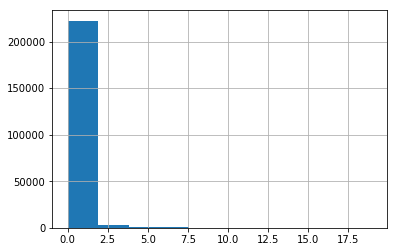

In [259]:
y_test.hist(bins=10)

(array([2.644e+03, 8.871e+03, 7.656e+03, 2.355e+03, 1.131e+03, 1.085e+03,
        3.720e+02, 3.720e+02, 1.800e+02, 1.590e+02, 1.130e+02, 9.200e+01,
        3.300e+01, 3.100e+01, 4.700e+01, 2.100e+01, 1.500e+01, 7.000e+00,
        0.000e+00, 1.000e+00, 4.000e+00, 3.000e+00, 1.000e+00, 0.000e+00,
        0.000e+00, 1.500e+01, 2.000e+00, 3.000e+00, 2.000e+00, 2.000e+00,
        1.000e+00, 3.000e+00, 5.000e+00, 3.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 1.000e+00, 0.000e+00, 1.000e+00, 1.000e+00, 4.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 1.000e+00, 1.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        1.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+0

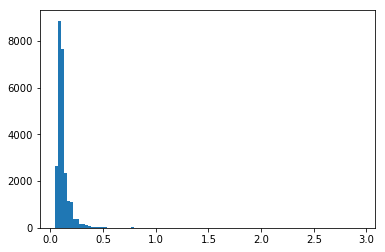

In [255]:
plt.hist(model.predict(x_test),bins=100)

In [251]:
mse(model.predict(x_train),y_train)

0.4950228421752919

In [248]:
traint=Dfinal2[:index]
traint['predicted']=model.predict(x_train)

traint.query('(REF=="D00935:00048:00048")& TIENDA=="PUNTO DE VENTA AV 68" ')

,REF,TIENDA,DATE,ANIO,MES,CANTIDAD,PRECIO,DESCUENTO(%),AREA,ALTO,PUESTOS,COLOR_POS,SUBCATEGORIA_POS,MATERIAL_POS,ACABADO,CATEGORIA,ORIGEN,F_COVID,predicted
6206,D00935:00048:00048,PUNTO DE VENTA AV 68,2019-01,2019,1,0.0,524356.000000,0.487180,16744.0,82.0,3.0,AZUL,SOFA CAMA ABATIBLE,MICROFIBRA,TEXTILES SUAVES,SALAS Y SOFAS,MANUFACTURADO,0,0.113636
12951,D00935:00048:00048,PUNTO DE VENTA AV 68,2019-02,2019,2,1.0,524356.000000,0.487180,16744.0,82.0,3.0,AZUL,SOFA CAMA ABATIBLE,MICROFIBRA,TEXTILES SUAVES,SALAS Y SOFAS,MANUFACTURADO,0,0.113636
19696,D00935:00048:00048,PUNTO DE VENTA AV 68,2019-03,2019,3,1.0,524356.000000,0.487180,16744.0,82.0,3.0,AZUL,SOFA CAMA ABATIBLE,MICROFIBRA,TEXTILES SUAVES,SALAS Y SOFAS,MANUFACTURADO,0,0.068748
26441,D00935:00048:00048,PUNTO DE VENTA AV 68,2019-04,2019,4,3.0,536470.000000,0.500000,16744.0,82.0,3.0,AZUL,SOFA CAMA ABATIBLE,MICROFIBRA,TEXTILES SUAVES,SALAS Y SOFAS,MANUFACTURADO,0,0.073683
33134,D00935:00048:00048,PUNTO DE VENTA AV 68,2019-05,2019,5,5.0,536470.125000,0.500000,16744.0,82.0,3.0,AZUL,SOFA CAMA ABATIBLE,MICROFIBRA,TEXTILES SUAVES,SALAS Y SOFAS,MANUFACTURADO,0,0.110026
39826,D00935:00048:00048,PUNTO DE VENTA AV 68,2019-06,2019,6,5.0,536470.375000,0.500000,16744.0,82.0,3.0,AZUL,SOFA CAMA ABATIBLE,MICROFIBRA,TEXTILES SUAVES,SALAS Y SOFAS,MANUFACTURADO,0,0.129699
46518,D00935:00048:00048,PUNTO DE VENTA AV 68,2019-07,2019,7,7.0,536470.291667,0.500000,16744.0,82.0,3.0,AZUL,SOFA CAMA ABATIBLE,MICROFIBRA,TEXTILES SUAVES,SALAS Y SOFAS,MANUFACTURADO,0,0.105229
53210,D00935:00048:00048,PUNTO DE VENTA AV 68,2019-08,2019,8,2.0,536470.000000,0.500000,16744.0,82.0,3.0,AZUL,SOFA CAMA ABATIBLE,MICROFIBRA,TEXTILES SUAVES,SALAS Y SOFAS,MANUFACTURADO,0,0.113636
59902,D00935:00048:00048,PUNTO DE VENTA AV 68,2019-09,2019,9,3.0,536470.000000,0.520885,16744.0,82.0,3.0,AZUL,SOFA CAMA ABATIBLE,MICROFIBRA,TEXTILES SUAVES,SALAS Y SOFAS,MANUFACTURADO,0,0.113636
66594,D00935:00048:00048,PUNTO DE VENTA AV 68,2019-10,2019,10,2.0,536470.000000,0.500000,16744.0,82.0,3.0,AZUL,SOFA CAMA ABATIBLE,MICROFIBRA,TEXTILES SUAVES,SALAS Y SOFAS,MANUFACTURADO,0,0.112206


In [42]:
def df_lag_generator(n):
    df_lag=Dfinal2.copy()
    for i in range(n):
        df_lag['CANTIDAD_{}'.format(i+1)]=df_lag.groupby(['REF','TIENDA'])[['CANTIDAD']].shift(i+1)
    return df_lag

In [43]:
Dfinal_lag=df_lag_generator(12).dropna().reset_index(drop=True)

In [44]:
Dfinal_lag

,REF,TIENDA,DATE,ANIO,MES,CANTIDAD,PRECIO,DESCUENTO(%),AREA,ALTO,PUESTOS,COLOR_POS,SUBCATEGORIA_POS,MATERIAL_POS,ACABADO,CATEGORIA,ORIGEN,F_COVID,CANTIDAD_1,CANTIDAD_2,CANTIDAD_3,CANTIDAD_4,CANTIDAD_5,CANTIDAD_6,CANTIDAD_7,CANTIDAD_8,CANTIDAD_9,CANTIDAD_10,CANTIDAD_11,CANTIDAD_12
0,XA0795:00046:,PUNTO DE VENTA CALLE 134,2020-01,2020,1,0.0,2.120130e+05,0.400702,2565.0,83.0,1.0,AZUL,SILLAS AUXILIARES,OTRO,TEXTURA SUAVE,SALAS Y SOFAS,IMPORTADO,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,XA0794:00029:,PUNTO DE VENTA PLAZA CENTRAL,2020-01,2020,1,2.0,8.790200e+04,0.500000,1681.0,90.0,1.0,GRIS,SILLAS AUXILIARES,OTRO,TEXTURA SUAVE,SALAS Y SOFAS,IMPORTADO,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,XA0794:00029:,PUNTO DE VENTA PLAZA IMPERIAL,2020-01,2020,1,6.0,8.790200e+04,0.500000,1681.0,90.0,1.0,GRIS,SILLAS AUXILIARES,OTRO,TEXTURA SUAVE,SALAS Y SOFAS,IMPORTADO,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,XA0795:00046:,ADMINISTRACION,2020-01,2020,1,0.0,2.120130e+05,0.502488,2565.0,83.0,1.0,AZUL,SILLAS AUXILIARES,OTRO,TEXTURA SUAVE,SALAS Y SOFAS,IMPORTADO,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,XA0795:00046:,PAGINA WEB FIOTTI,2020-01,2020,1,0.0,1.060060e+05,0.000000,2565.0,83.0,1.0,AZUL,SILLAS AUXILIARES,OTRO,TEXTURA SUAVE,SALAS Y SOFAS,IMPORTADO,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,XA0795:00046:,PUNTO DE VENTA AV 68,2020-01,2020,1,0.0,2.120127e+05,0.350000,2565.0,83.0,1.0,AZUL,SILLAS AUXILIARES,OTRO,TEXTURA SUAVE,SALAS Y SOFAS,IMPORTADO,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,XA0795:00046:,PUNTO DE VENTA CALI,2020-01,2020,1,0.0,2.120125e+05,0.450000,2565.0,83.0,1.0,AZUL,SILLAS AUXILIARES,OTRO,TEXTURA SUAVE,SALAS Y SOFAS,IMPORTADO,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,XA0795:00046:,PUNTO DE VENTA CENTRO MAYOR,2020-01,2020,1,0.0,2.120130e+05,0.350000,2565.0,83.0,1.0,AZUL,SILLAS AUXILIARES,OTRO,TEXTURA SUAVE,SALAS Y SOFAS,IMPORTADO,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,XA0796:00108:,PUNTO DE VENTA LAURELES,2020-01,2020,1,0.0,2.395740e+05,0.599998,2565.0,83.0,1.0,AMARILLO,SILLAS AUXILIARES,OTRO,TEXTURA SUAVE,SALAS Y SOFAS,IMPORTADO,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,XA0795:00046:,PUNTO DE VENTA PLAZA CENTRAL,2020-01,2020,1,0.0,2.120130e+05,0.400702,2565.0,83.0,1.0,AZUL,SILLAS AUXILIARES,OTRO,TEXTURA SUAVE,SALAS Y SOFAS,IMPORTADO,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [45]:

num_var=['AREA','ALTO','DESCUENTO(%)','PRECIO']
for i in range(1,13):
    num_var.append('CANTIDAD_{}'.format(i))
num_var.append('CANTIDAD')
x_num=Dfinal_lag[num_var[:-1]].astype('float')


cat_var=[
    'MES','TIENDA', 'PUESTOS', 'COLOR_POS', 'SUBCATEGORIA_POS', 'F_COVID' ,'MATERIAL_POS','ACABADO','CATEGORIA','ORIGEN'#quitamos anio, vigencia y estilo-validado errro casi no cambia
]
x_cat=Dfinal_lag[cat_var].astype('category')
x_cat_dummies=pd.get_dummies(x_cat)

y = Dfinal_lag['CANTIDAD']

scaler = MinMaxScaler()
x_num_norm = scaler.fit_transform(x_num)
x = np.append(x_num_norm,x_cat_dummies,axis=1)

#split data till januar 2021

index = Dfinal_lag[(Dfinal_lag.ANIO==2021)].index[0]
date_index=Dfinal_lag[(Dfinal_lag.ANIO==2021)]['DATE'].values[0]
date_indebef=Dfinal_lag.iloc[index-1]['DATE']
date_indeaf=Dfinal_lag.iloc[index+1]['DATE']

x_train = x[:index]
y_train = y[:index]
x_test = x[index:]
y_test = y[index:]

In [47]:
from sklearn.ensemble import GradientBoostingRegressor

In [51]:
%%time
model = GradientBoostingRegressor(**{'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 200})
model.fit(x_train,y_train)

Wall time: 3min 21s


In [49]:
mse(model.predict(x_train),y_train)

0.9583387684492845

In [50]:
mse(model.predict(x_test),y_test)

0.6676597171326354

In [310]:
traint=Dfinal_lag[:index]
traint['predicted']=model.predict(x_train)

traint.query('(REF=="D00935:00048:00048")& TIENDA=="PUNTO DE VENTA AV 68" ')

,REF,TIENDA,DATE,ANIO,MES,CANTIDAD,PRECIO,DESCUENTO(%),AREA,ALTO,PUESTOS,COLOR_POS,SUBCATEGORIA_POS,MATERIAL_POS,ACABADO,CATEGORIA,ORIGEN,F_COVID,CANTIDAD_1,CANTIDAD_2,CANTIDAD_3,CANTIDAD_4,CANTIDAD_5,CANTIDAD_6,CANTIDAD_7,CANTIDAD_8,CANTIDAD_9,CANTIDAD_10,CANTIDAD_11,CANTIDAD_12,predicted
6154,D00935:00048:00048,PUNTO DE VENTA AV 68,2020-01,2020,1,1.0,536470.000000,0.5,16744.0,82.0,3.0,AZUL,SOFA CAMA ABATIBLE,MICROFIBRA,TEXTILES SUAVES,SALAS Y SOFAS,MANUFACTURADO,0,2.0,2.0,2.0,3.0,2.0,7.0,5.0,5.0,3.0,1.0,1.0,0.0,0.579248
12846,D00935:00048:00048,PUNTO DE VENTA AV 68,2020-02,2020,2,7.0,536470.000000,0.5,16744.0,82.0,3.0,AZUL,SOFA CAMA ABATIBLE,MICROFIBRA,TEXTILES SUAVES,SALAS Y SOFAS,MANUFACTURADO,0,1.0,2.0,2.0,2.0,3.0,2.0,7.0,5.0,5.0,3.0,1.0,1.0,0.579248
19538,D00935:00048:00048,PUNTO DE VENTA AV 68,2020-03,2020,3,3.0,581288.666667,0.5,16744.0,82.0,3.0,AZUL,SOFA CAMA ABATIBLE,MICROFIBRA,TEXTILES SUAVES,SALAS Y SOFAS,MANUFACTURADO,3,7.0,1.0,2.0,2.0,2.0,3.0,2.0,7.0,5.0,5.0,3.0,1.0,1.128536
23911,D00935:00048:00048,PUNTO DE VENTA AV 68,2020-04,2020,4,0.0,587774.772218,0.5,16744.0,82.0,3.0,AZUL,SOFA CAMA ABATIBLE,MICROFIBRA,TEXTILES SUAVES,SALAS Y SOFAS,MANUFACTURADO,3,3.0,7.0,1.0,2.0,2.0,2.0,3.0,2.0,7.0,5.0,5.0,3.0,0.212327
28741,D00935:00048:00048,PUNTO DE VENTA AV 68,2020-05,2020,5,0.0,594764.277006,0.5,16744.0,82.0,3.0,AZUL,SOFA CAMA ABATIBLE,MICROFIBRA,TEXTILES SUAVES,SALAS Y SOFAS,MANUFACTURADO,1,0.0,3.0,7.0,1.0,2.0,2.0,2.0,3.0,2.0,7.0,5.0,5.0,0.361995
34091,D00935:00048:00048,PUNTO DE VENTA AV 68,2020-06,2020,6,1.0,603698.000000,0.5,16744.0,82.0,3.0,AZUL,SOFA CAMA ABATIBLE,MICROFIBRA,TEXTILES SUAVES,SALAS Y SOFAS,MANUFACTURADO,1,0.0,0.0,3.0,7.0,1.0,2.0,2.0,2.0,3.0,2.0,7.0,5.0,0.352280
40374,D00935:00048:00048,PUNTO DE VENTA AV 68,2020-07,2020,7,4.0,603698.000000,0.5,16744.0,82.0,3.0,AZUL,SOFA CAMA ABATIBLE,MICROFIBRA,TEXTILES SUAVES,SALAS Y SOFAS,MANUFACTURADO,1,1.0,0.0,0.0,3.0,7.0,1.0,2.0,2.0,2.0,3.0,2.0,7.0,0.627008
46732,D00935:00048:00048,PUNTO DE VENTA AV 68,2020-08,2020,8,1.0,603698.000000,0.5,16744.0,82.0,3.0,AZUL,SOFA CAMA ABATIBLE,MICROFIBRA,TEXTILES SUAVES,SALAS Y SOFAS,MANUFACTURADO,2,4.0,1.0,0.0,0.0,3.0,7.0,1.0,2.0,2.0,2.0,3.0,2.0,0.931807
53090,D00935:00048:00048,PUNTO DE VENTA AV 68,2020-09,2020,9,2.0,603698.000000,0.5,16744.0,82.0,3.0,AZUL,SOFA CAMA ABATIBLE,MICROFIBRA,TEXTILES SUAVES,SALAS Y SOFAS,MANUFACTURADO,2,1.0,4.0,1.0,0.0,0.0,3.0,7.0,1.0,2.0,2.0,2.0,3.0,0.567046
59755,D00935:00048:00048,PUNTO DE VENTA AV 68,2020-10,2020,10,1.0,603698.000000,0.5,16744.0,82.0,3.0,AZUL,SOFA CAMA ABATIBLE,MICROFIBRA,TEXTILES SUAVES,SALAS Y SOFAS,MANUFACTURADO,1,2.0,1.0,4.0,1.0,0.0,0.0,3.0,7.0,1.0,2.0,2.0,2.0,0.543247


In [322]:
X_train.shape

(20341, 95)

In [70]:
import statsmodels.api as sm

mod = sm.OLS(y_train, sm.add_constant(x_train))
res = mod.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               CANTIDAD   R-squared:                       0.148
Model:                            OLS   Adj. R-squared:                  0.147
Method:                 Least Squares   F-statistic:                     151.0
Date:                Wed, 01 Sep 2021   Prob (F-statistic):               0.00
Time:                        21:04:25   Log-Likelihood:            -1.0095e+05
No. Observations:               73344   AIC:                         2.021e+05
Df Residuals:                   73259   BIC:                         2.029e+05
Df Model:                          84                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0406      0.014      2.841      0.005       0.013       0.069
x1             0.0785      0.055      1.421      0.155      -0.030       0.187
x2            -0.0621      0.043     -1.433      0.152      -0.147       0.023
x3             0.0057      0.022      0.258      0.797      -0.038       0.049
x4            -0.1403      0.053     -2.651      0.008      -0.244      -0.037
x5             4.8738      0.069     70.754      0.000       4.739       5.009
x6             1.4135      0.070     20.152      0.000       1.276       1.551
x7             0.4990      0.071      7.058      0.000       0.360       0.638
x8             0.4943      0.070      7.080      0.000       0.357       0.631
x9             0.2917      0.069      4.225      0.000       0.156       0.427
x10            0.2292      0.067      3.405      0.001       0.097       0.361
x11            0.0119      0.067      0.177      0.859      -0.120       0.143
x12            0.0287      0.065      0.439      0.661      -0.100       0.157
x13            0.1278      0.065      1.965      0.049       0.000       0.255
x14            0.1191      0.065      1.824      0.068      -0.009       0.247
x15            0.0520      0.067      0.772      0.440      -0.080       0.184
x16            0.1378      0.068      2.030      0.042       0.005       0.271
x17            0.0263      0.009      2.985      0.003       0.009       0.044
x18            0.0618      0.009      7.020      0.000       0.045       0.079
x19            0.0276      0.009      2.906      0.004       0.009       0.046
x20           -0.1401      0.011    -13.096      0.000      -0.161      -0.119
x21           -0.1962      0.012    -15.975      0.000      -0.220      -0.172
x22            0.0629      0.012      5.351      0.000       0.040       0.086
x23           -0.0099      0.011     -0.906      0.365      -0.031       0.012
x24           -0.0591      0.010     -5.890      0.000      -0.079      -0.039
x25            0.0476      0.010      4.742      0.000       0.028       0.067
x26            0.0674      0.011      6.268      0.000       0.046       0.089
x27            0.1158      0.011     10.748      0.000       0.095       0.137
x28            0.0366      0.010      3.638      0.000       0.017       0.056
x29           -0.0572      0.012     -4.895      0.000      -0.080      -0.034
x30            0.0696      0.015      4.768      0.000       0.041       0.098
x31            0.1916      0.009     20.788      0.000       0.174       0.210
x32           -0.0023      0.011     -0.212      0.832      -0.023       0.019
x33            0.0756      0.010      7.315      0.000       0.055       0.096
x34            0.0394      0.010      3.969      0.000       0.020       0.059
x35           -0.0753      0.016     -4.785      0.000      -0.106      -0.044
x3

In [71]:
cols=x_num.columns.append(x_cat_dummies.columns)
list(zip(cols,res.params[1:],res.pvalues[1:]))

[('AREA', 0.0785470252494157, 0.15538333476441774),
 ('ALTO', -0.062118366465598054, 0.15193777500572506),
 ('DESCUENTO(%)', 0.005717740476119643, 0.7965723438463217),
 ('PRECIO', -0.14030361317802856, 0.008032437742247494),
 ('CANTIDAD_1', 4.873762912517318, 0.0),
 ('CANTIDAD_2', 1.4134545619763614, 4.543425040777262e-90),
 ('CANTIDAD_3', 0.4990418915312183, 1.7021804920456933e-12),
 ('CANTIDAD_4', 0.4942979163371355, 1.4496173302037665e-12),
 ('CANTIDAD_5', 0.29165394841936315, 2.390047213235346e-05),
 ('CANTIDAD_6', 0.2291814908105153, 0.0006628108350875512),
 ('CANTIDAD_7', 0.01189038853842422, 0.8593624954757121),
 ('CANTIDAD_8', 0.02871069631462675, 0.660975363998515),
 ('CANTIDAD_9', 0.12775428156467195, 0.04938530760491333),
 ('CANTIDAD_10', 0.11914247609623288, 0.06810566403669518),
 ('CANTIDAD_11', 0.052022707032706283, 0.4402152919014728),
 ('CANTIDAD_12', 0.13778624202259085, 0.042407859751589096),
 ('MES_1', 0.026263766807779435, 0.002833674762054303),
 ('MES_2', 0.0617788

In [72]:
mse(y_train,res.predict(sm.add_constant(x_train)))

0.9185415011356388

In [73]:
mse(y_test,res.predict(sm.add_constant(x_test,has_constant='add')))

0.6662446738617412

In [386]:
res.predict(sm.add_constant(x_train))

array([0.59815109, 0.46439319, 0.50240023, ..., 0.19165262, 0.15944573,
       0.28177112])

In [79]:
traint=Dfinal_lag[:index]
traint['predicted']=res.predict(sm.add_constant(x_train))
traint['predicted']=r.predict(x_train)

traint.query('(REF=="D00935:00048:00048")& TIENDA=="PUNTO DE VENTA AV 68" ')

,REF,TIENDA,DATE,ANIO,MES,CANTIDAD,PRECIO,DESCUENTO(%),AREA,ALTO,PUESTOS,COLOR_POS,SUBCATEGORIA_POS,MATERIAL_POS,ACABADO,CATEGORIA,ORIGEN,F_COVID,CANTIDAD_1,CANTIDAD_2,CANTIDAD_3,CANTIDAD_4,CANTIDAD_5,CANTIDAD_6,CANTIDAD_7,CANTIDAD_8,CANTIDAD_9,CANTIDAD_10,CANTIDAD_11,CANTIDAD_12,predicted
6154,D00935:00048:00048,PUNTO DE VENTA AV 68,2020-01,2020,1,1.0,536470.000000,0.5,16744.0,82.0,3.0,AZUL,SOFA CAMA ABATIBLE,MICROFIBRA,TEXTILES SUAVES,SALAS Y SOFAS,MANUFACTURADO,0,2.0,2.0,2.0,3.0,2.0,7.0,5.0,5.0,3.0,1.0,1.0,0.0,1.353381
12846,D00935:00048:00048,PUNTO DE VENTA AV 68,2020-02,2020,2,7.0,536470.000000,0.5,16744.0,82.0,3.0,AZUL,SOFA CAMA ABATIBLE,MICROFIBRA,TEXTILES SUAVES,SALAS Y SOFAS,MANUFACTURADO,0,1.0,2.0,2.0,2.0,3.0,2.0,7.0,5.0,5.0,3.0,1.0,1.0,1.097202
19538,D00935:00048:00048,PUNTO DE VENTA AV 68,2020-03,2020,3,3.0,581288.666667,0.5,16744.0,82.0,3.0,AZUL,SOFA CAMA ABATIBLE,MICROFIBRA,TEXTILES SUAVES,SALAS Y SOFAS,MANUFACTURADO,3,7.0,1.0,2.0,2.0,2.0,3.0,2.0,7.0,5.0,5.0,3.0,1.0,2.333153
23911,D00935:00048:00048,PUNTO DE VENTA AV 68,2020-04,2020,4,0.0,587774.772218,0.5,16744.0,82.0,3.0,AZUL,SOFA CAMA ABATIBLE,MICROFIBRA,TEXTILES SUAVES,SALAS Y SOFAS,MANUFACTURADO,3,3.0,7.0,1.0,2.0,2.0,2.0,3.0,2.0,7.0,5.0,5.0,3.0,1.578143
28741,D00935:00048:00048,PUNTO DE VENTA AV 68,2020-05,2020,5,0.0,594764.277006,0.5,16744.0,82.0,3.0,AZUL,SOFA CAMA ABATIBLE,MICROFIBRA,TEXTILES SUAVES,SALAS Y SOFAS,MANUFACTURADO,1,0.0,3.0,7.0,1.0,2.0,2.0,2.0,3.0,2.0,7.0,5.0,5.0,0.737083
34091,D00935:00048:00048,PUNTO DE VENTA AV 68,2020-06,2020,6,1.0,603698.000000,0.5,16744.0,82.0,3.0,AZUL,SOFA CAMA ABATIBLE,MICROFIBRA,TEXTILES SUAVES,SALAS Y SOFAS,MANUFACTURADO,1,0.0,0.0,3.0,7.0,1.0,2.0,2.0,2.0,3.0,2.0,7.0,5.0,0.787179
40374,D00935:00048:00048,PUNTO DE VENTA AV 68,2020-07,2020,7,4.0,603698.000000,0.5,16744.0,82.0,3.0,AZUL,SOFA CAMA ABATIBLE,MICROFIBRA,TEXTILES SUAVES,SALAS Y SOFAS,MANUFACTURADO,1,1.0,0.0,0.0,3.0,7.0,1.0,2.0,2.0,2.0,3.0,2.0,7.0,0.867350
46732,D00935:00048:00048,PUNTO DE VENTA AV 68,2020-08,2020,8,1.0,603698.000000,0.5,16744.0,82.0,3.0,AZUL,SOFA CAMA ABATIBLE,MICROFIBRA,TEXTILES SUAVES,SALAS Y SOFAS,MANUFACTURADO,2,4.0,1.0,0.0,0.0,3.0,7.0,1.0,2.0,2.0,2.0,3.0,2.0,1.536169
53090,D00935:00048:00048,PUNTO DE VENTA AV 68,2020-09,2020,9,2.0,603698.000000,0.5,16744.0,82.0,3.0,AZUL,SOFA CAMA ABATIBLE,MICROFIBRA,TEXTILES SUAVES,SALAS Y SOFAS,MANUFACTURADO,2,1.0,4.0,1.0,0.0,0.0,3.0,7.0,1.0,2.0,2.0,2.0,3.0,1.038970
59755,D00935:00048:00048,PUNTO DE VENTA AV 68,2020-10,2020,10,1.0,603698.000000,0.5,16744.0,82.0,3.0,AZUL,SOFA CAMA ABATIBLE,MICROFIBRA,TEXTILES SUAVES,SALAS Y SOFAS,MANUFACTURADO,1,2.0,1.0,4.0,1.0,0.0,0.0,3.0,7.0,1.0,2.0,2.0,2.0,1.167346


In [82]:
testt=Dfinal_lag[index:]


In [92]:
testt['predicted']=res.predict(sm.add_constant(x_test))
testt['predicted']=res.predict(sm.add_constant(x_test))


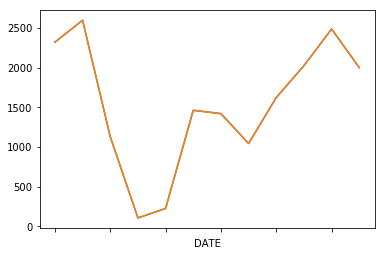

In [88]:
traint.groupby('DATE').sum()['CANTIDAD'].plot()
traint.groupby('DATE').sum()['predicted'].plot()

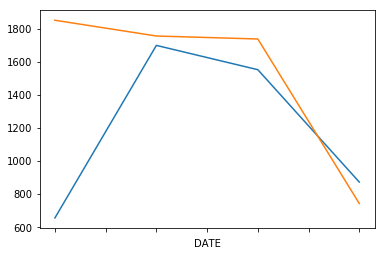

In [93]:
testt.groupby('DATE').sum()['CANTIDAD'].plot()
testt.groupby('DATE').sum()['predicted'].plot()

In [393]:
res.predict(sm.add_constant(x_test))[-5:]

array([ 0.19914706, -0.05413969,  0.02981013, -0.00239675,  0.11992864])

In [54]:
from sklearn.linear_model import LinearRegression

In [55]:
lr=LinearRegression()
lr.fit(x_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [56]:
traint['predicted']=lr.predict(x_train)
traint.query('(REF=="D00935:00048:00048")& TIENDA=="PUNTO DE VENTA AV 68" ')

ValueError: Length of values does not match length of index

In [65]:
mse(lr.predict(x_test),y_test)

7.386926082504118e+26

In [142]:
from sklearn.linear_model import Lasso,Ridge
l=Lasso().fit(x_train,y_train)
r=Ridge(alpha=1000).fit(x_train,y_train)

In [143]:
mse(r.predict(x_test),y_test)

0.6659237475290399

In [144]:
mse(r.predict(x_train),y_train)

0.9782486809161465

In [321]:
num_var=['AREA','ALTO','DESCUENTO(%)','PRECIO']
for i in range(1,13):
    num_var.append('CANTIDAD_{}'.format(i))
num_var.append('CANTIDAD')
cat_var=['MES','Factor covid','PUESTOS','COLOR_POS','CATEGORIA','SUBCATEGORIA_POS','VIGENCIA','ORIGEN','ESTILO','MATERIAL_POS','ACABADO']

y=sales_ref_month2_lag['CANTIDAD']

X_num=sales_ref_month2_lag[num_var[:-1]].astype('float')
X_cat=sales_ref_month2_lag[cat_var].astype('category')

X_cat_dummies=pd.get_dummies(X_cat)

from sklearn.preprocessing import MinMaxScaler

scaler=MinMaxScaler()
X_num_norm= scaler.fit_transform(X_num)


X=np.append(X_num_norm,X_cat_dummies,axis=1)

#split data till month 4 from 2021
index=sales_ref_month2_lag[(sales_ref_month2_lag.ANIO==2021) & (sales_ref_month2_lag.MES==4)].head(1).index.values[0]
X_train=X[:index-1]
y_train=(y[:index-1])
X_test=X[index:]
y_test=(y[index:])


import statsmodels.api as sm
from sklearn.metrics import mean_squared_error as mse

mod = sm.OLS(y_train, sm.add_constant(X_train))
res = mod.fit()
res.summary()



<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               CANTIDAD   R-squared:                       0.305
Model:                            OLS   Adj. R-squared:                  0.222
Method:                 Least Squares   F-statistic:                     3.685
Date:                Sat, 28 Aug 2021   Prob (F-statistic):           2.28e-20
Time:                        05:17:28   Log-Likelihood:                -1562.7
No. Observations:                 744   AIC:                             3285.
Df Residuals:                     664   BIC:                             3654.
Df Model:                          79                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.1050      0.454     -0.231      0.817      -0.997       0.787
x1             0.1806      2.084      0.087      0.931      -3.912       4.273
x2            -0.2439      1.276     -0.191      0.849      -2.750       2.262
x3             0.5702      0.576      0.990      0.322      -0.561       1.701
x4             0.6542      1.691      0.387      0.699      -2.667       3.975
x5             2.4980      0.374      6.684      0.000       1.764       3.232
x6             0.0086      0.371      0.023      0.981      -0.719       0.736
x7             0.7836      0.362      2.163      0.031       0.072       1.495
x8             0.6336      0.365      1.735      0.083      -0.083       1.351
x9            -0.0598      0.370     -0.162      0.872      -0.786       0.666
x10           -0.2188      0.362     -0.605      0.546      -0.929       0.492
x11            0.1451      0.365      0.397      0.691      -0.572       0.862
x12           -0.5431      0.363     -1.494      0.136      -1.257       0.171
x13            0.4406      0.362      1.217      0.224      -0.271       1.152
x14            0.5896      0.356      1.656      0.098      -0.109       1.289
x15            0.0622      0.363      0.171      0.864      -0.651       0.775
x16            0.7453      0.361      2.062      0.040       0.036       1.455
x17            0.2388      0.638      0.374      0.708      -1.014       1.491
x18           -0.3357      0.369     -0.910      0.363      -1.060       0.389
x19           -0.5056      0.396     -1.278      0.202      -1.282       0.271
x20           -1.2426      1.153     -1.078      0.282      -3.507       1.022
x21           -1.7293      0.611     -2.832      0.005      -2.928      -0.530
x22           -0.0197      0.486     -0.041      0.968      -0.974       0.934
x23           -0.4957      0.453     -1.094      0.275      -1.386       0.394
x24            1.0673      0.733      1.457      0.146      -0.371       2.506
x25            1.6606      0.724      2.295      0.022       0.240       3.081
x26            0.1315      0.421      0.312      0.755      -0.696       0.959
x27            0.0290      0.421      0.069      0.945      -0.798       0.856
x28            1.0964      0.707      1.551      0.121      -0.292       2.485
x29            1.0889      0.390      2.794      0.005       0.324       1.854
x30            0.4910      0.380      1.294      0.196      -0.254       1.236
x31           -1.1975      0.687     -1.743      0.082      -2.547       0.152
x32           -0.4874      0.516     -0.944      0.346      -1.501       0.526
x33            0.1590      1.336      0.119      0.905      -2.464       2.782
x34            0.7995      0.614      1.303      0.193      -0.406       2.005
x35           -0.1987      1.340     -0.148      0.882      -2.829       2.432
x3

In [322]:
y_predicted=res.predict(sm.add_constant(X_test, has_constant='add'))
mse(y_test,y_predicted)

2.6984281296978194

In [316]:
sales_test=sales_ref_month2_lag.loc[index:]
sales_test['predic']= y_predicted

In [288]:
pf=sales_test.groupby(['ANIO','MES','COLOR_POS','CATEGORIA','SUBCATEGORIA_POS','MATERIAL_POS','ESTILO','ACABADO','PUESTOS','VIGENCIA','ORIGEN']).agg({'predic':'sum','CANTIDAD':'sum'}).reset_index()
pf

,ANIO,MES,COLOR_POS,CATEGORIA,SUBCATEGORIA_POS,MATERIAL_POS,ESTILO,ACABADO,PUESTOS,VIGENCIA,ORIGEN,predic,CANTIDAD
0,2021,4,AMARILLO,SALAS Y SOFAS,SILLAS AUXILIARES,MICROFIBRA,CONTEMPORÁNEO,TEXTILES SUAVES,1.0,LINEA,IMPORTADO,4.111863,6
1,2021,4,AMARILLO,SALAS Y SOFAS,SOFA 2P,MICROFIBRA,CONTEMPORÁNEO,TEXTILES SUAVES,2.0,DESCONTINUADO,MANUFACTURADO,2.788739,2
2,2021,4,AMARILLO,SALAS Y SOFAS,SOFA 2P,MICROFIBRA,CONTEMPORÁNEO,TEXTILES SUAVES,2.0,LINEA,MANUFACTURADO,3.249724,7
3,2021,4,AMARILLO,SALAS Y SOFAS,SOFA 3P,MICROFIBRA,CONTEMPORÁNEO,TEXTILES SUAVES,3.0,DESCONTINUADO,MANUFACTURADO,2.319678,1
4,2021,4,AMARILLO,SALAS Y SOFAS,SOFA 3P,MICROFIBRA,CONTEMPORÁNEO,TEXTILES SUAVES,3.0,LINEA,MANUFACTURADO,1.784623,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...
70,2021,4,OTRO,SALAS Y SOFAS,POLTRONAS,MICROFIBRA,CONTEMPORÁNEO,MADERA NATURAL,1.0,LINEA,MANUFACTURADO,4.210586,3
71,2021,4,OTRO,SALAS Y SOFAS,PUFF,MICROFIBRA,CONTEMPORÁNEO,TEXTILES SUAVES,1.0,DESCONTINUADO,IMPORTADO,1.805757,3
72,2021,4,OTRO,SALAS Y SOFAS,SILLAS AUXILIARES,MICROFIBRA,MODERNO,TEXTILES SUAVES,1.0,LINEA,MANUFACTURADO,2.063431,1
73,2021,4,OTRO,SALAS Y SOFAS,SOFA CAMA ABATIBLE,MICROFIBRA,CONTEMPORÁNEO,TEXTILES SUAVES,3.0,NOVEDAD,MANUFACTURADO,2.106600,4


In [199]:
mse(pf.CANTIDAD,pf.predic)

3.014070591660885

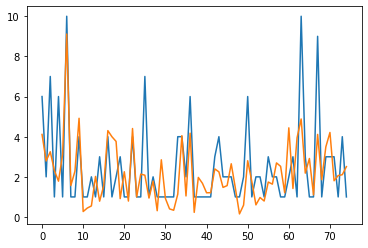

In [289]:
plt.plot(pf.CANTIDAD)
plt.plot(pf.predic)

In [67]:
y_test

745    1
746    2
747    1
748    4
749    1
      ..
819    2
820    1
821    1
822    2
823    3
Name: CANTIDAD, Length: 79, dtype: int64

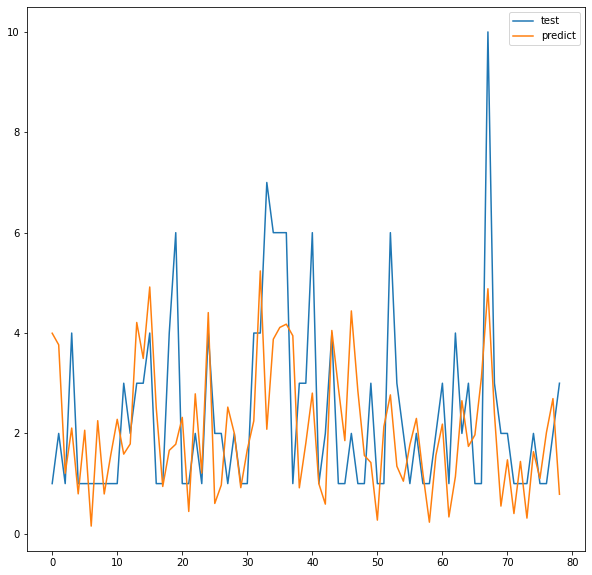

In [70]:
plt.figure(figsize=(10,10))
plt.plot(range(len(res.predict(sm.add_constant(X_test, has_constant='add')))),y_test,label='test')
plt.plot(range(len(res.predict(sm.add_constant(X_test, has_constant='add')))),res.predict(sm.add_constant(X_test, has_constant='add')),label='predict')
plt.legend()

In [90]:
br=GradientBoostingRegressor(**{'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 40})

br.fit(X_train,y_train)


GradientBoostingRegressor(max_depth=7, n_estimators=40)

In [94]:
mse(y_test,br.predict(X_test))

2.2688266683860565

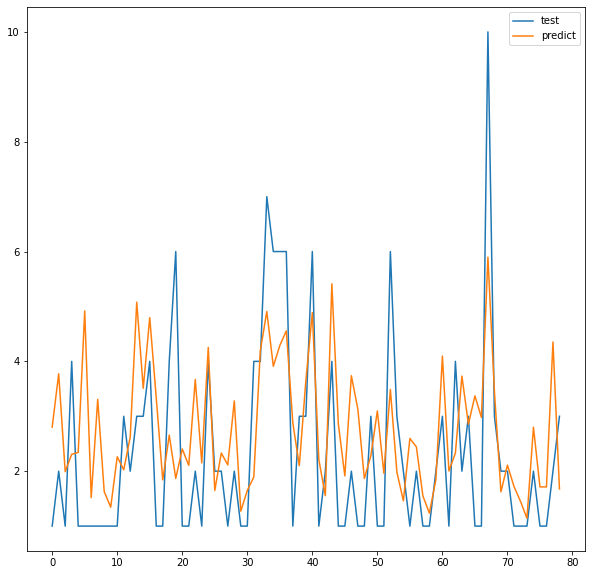

In [92]:

plt.figure(figsize=(10,10))
plt.plot(range(len(br.predict(X_test))),y_test,label='test')
plt.plot(range(len(br.predict(X_test))),br.predict(X_test),label='predict')
plt.legend()

In [93]:
param_dist = {'n_estimators':[30, 40, 100, 200, 300],'learning_rate':[0.01, 0.05, 0.1, 0.3, 0.4, 1], 'max_depth': [2,4,6,8,10]}

grid_br_mae = GridSearchCV(GradientBoostingRegressor(), param_grid = param_dist,cv=3,n_jobs=4,scoring='neg_mean_absolute_error')
grid_br_mae.fit(X_train, y_train)



GridSearchCV(cv=3, estimator=GradientBoostingRegressor(), n_jobs=4,
             param_grid={'learning_rate': [0.01, 0.05, 0.1, 0.3, 0.4, 1],
                         'max_depth': [2, 4, 6, 8, 10],
                         'n_estimators': [30, 40, 100, 200, 300]},
             scoring='neg_mean_absolute_error')

In [95]:
grid_br_mae.best_score_

-1.69432194373168

In [96]:
grid_br_mae.best_params_

{'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 30}

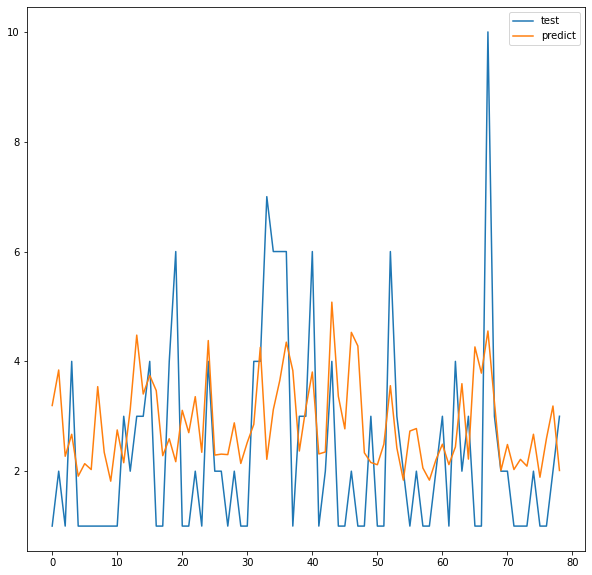

In [97]:

plt.figure(figsize=(10,10))
plt.plot(range(len(br.predict(X_test))),y_test,label='test')
plt.plot(range(len(br.predict(X_test))),grid_br_mae.predict(X_test),label='predict')
plt.legend()

In [99]:
grid_br_mape = GridSearchCV(GradientBoostingRegressor(), param_grid = param_dist,cv=3,n_jobs=4,scoring='neg_mean_absolute_percentage_error')
grid_br_mape.fit(X_train, y_train)


GridSearchCV(cv=3, estimator=GradientBoostingRegressor(), n_jobs=4,
             param_grid={'learning_rate': [0.01, 0.05, 0.1, 0.3, 0.4, 1],
                         'max_depth': [2, 4, 6, 8, 10],
                         'n_estimators': [30, 40, 100, 200, 300]},
             scoring='neg_mean_absolute_percentage_error')

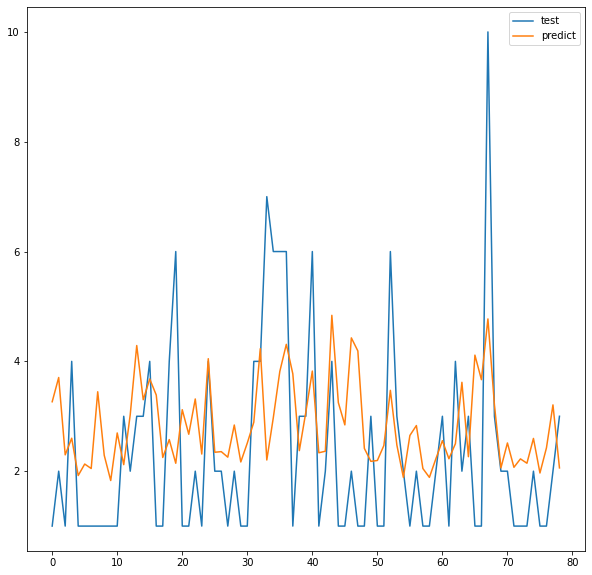

In [100]:

plt.figure(figsize=(10,10))
plt.plot(range(len(br.predict(X_test))),y_test,label='test')
plt.plot(range(len(br.predict(X_test))),grid_br_mape.predict(X_test),label='predict')
plt.legend()

In [102]:
from sklearn.metrics import mean_absolute_percentage_error as mape
mape(grid_br_mape.predict(X_test),y_test)

0.4950633495704558

Una forma mas general por caracteristicas

In [267]:
sales_cat=sales_ref_month2.groupby(['ANIO','MES','COLOR_POS','CATEGORIA','SUBCATEGORIA_POS','MATERIAL_POS','ESTILO','ACABADO','PUESTOS','VIGENCIA','ORIGEN']).agg({'PRECIO':'mean','SUBTOTAL':'sum','DESCUENTO(%)':'mean','TOTAL':'sum','CANTIDAD':'sum','ALTO':'mean','AREA':'mean','Factor covid':'first'}).reset_index()

In [272]:

sales_cat

,ANIO,MES,COLOR_POS,CATEGORIA,SUBCATEGORIA_POS,MATERIAL_POS,ESTILO,ACABADO,PUESTOS,VIGENCIA,ORIGEN,PRECIO,SUBTOTAL,DESCUENTO(%),TOTAL,CANTIDAD,ALTO,AREA,Factor covid
0,2019,1,AMARILLO,COMEDORES,SET 4P,VIDRIO,CONTEMPORÁNEO,BRILLANTE,4.0,DESCONTINUADO,IMPORTADO,1.031024e+06,1031024,0.600000,412410,1,75.0,10000.0,0
1,2019,1,AMARILLO,COMEDORES,SILLAS DE COMEDOR,MICROFIBRA,CONTEMPORÁNEO,TEXTILES SUAVES,1.0,NOVEDAD,IMPORTADO,2.462980e+05,246298,0.000000,246298,1,77.0,1880.0,0
2,2019,1,AMARILLO,SALAS Y SOFAS,SILLAS AUXILIARES,MICROFIBRA,CONTEMPORÁNEO,TEXTILES SUAVES,1.0,LINEA,IMPORTADO,1.902940e+05,190294,0.599998,76118,1,78.0,2200.0,0
3,2019,1,AZUL,COMEDORES,OTROS,MICROFIBRA,MODERNO,TEXTILES SUAVES,1.0,DESCONTINUADO,IMPORTADO,2.469570e+05,493914,0.175000,407479,2,100.0,3000.0,0
4,2019,1,AZUL,SALAS Y SOFAS,MESAS DE CENTRO,VIDRIO,CONTEMPORÁNEO,BRILLANTE,0.0,DESCONTINUADO,IMPORTADO,5.460780e+05,546078,0.500000,273039,1,50.0,7200.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6557,2021,4,OTRO,SALAS Y SOFAS,SOFA CAMA ABATIBLE,MICROFIBRA,MODERNO,TEXTILES SUAVES,3.0,LINEA,MANUFACTURADO,6.610620e+05,661062,0.543489,301782,1,82.0,16744.0,1
6558,2021,4,ROJO,SALAS Y SOFAS,POLTRONAS,MICROFIBRA,CONTEMPORÁNEO,TEXTILES SUAVES,1.0,NOVEDAD,IMPORTADO,6.157650e+05,615765,0.390907,375058,1,80.0,3819.0,1
6559,2021,4,ROJO,SALAS Y SOFAS,POLTRONAS,MICROFIBRA,CONTEMPORÁNEO,TEXTILES SUAVES,1.0,NOVEDAD,NACIONAL,5.626908e+05,6152812,0.515910,3173041,11,77.0,4104.0,1
6560,2021,4,ROJO,SALAS Y SOFAS,SOFA 2P,OTRO,CONTEMPORÁNEO,TEXTILES SUAVES,2.0,NOVEDAD,MANUFACTURADO,1.349659e+06,8097952,0.546970,3665683,6,77.0,13833.0,1


In [372]:
num_var=['AREA','ALTO','DESCUENTO(%)','PRECIO','CANTIDAD',]
cat_var=['MES','Factor covid','PUESTOS','COLOR_POS','CATEGORIA','SUBCATEGORIA_POS','VIGENCIA','ORIGEN','ESTILO','MATERIAL_POS','ACABADO']

y=sales_cat['CANTIDAD']

X_num=sales_cat[num_var[:-1]].astype('float')
X_cat=sales_cat[cat_var].astype('category')

X_cat_dummies=pd.get_dummies(X_cat)

from sklearn.preprocessing import MinMaxScaler

scaler=MinMaxScaler()
X_num_norm= scaler.fit_transform(X_num)


X=np.append(X_num_norm,X_cat_dummies,axis=1)

#split data till januar 2021
index=sales_cat[(sales_cat.ANIO==2021)].index[0]
X_train=X[:index-1]
y_train=y[:index-1]
X_test=X[index:]
y_test=y[index:]


import statsmodels.api as sm
from sklearn.metrics import mean_squared_error as mse

mod = sm.OLS(y_train, sm.add_constant(X_train))
res = mod.fit()
res.summary()




<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               CANTIDAD   R-squared:                       0.144
Model:                            OLS   Adj. R-squared:                  0.133
Method:                 Least Squares   F-statistic:                     13.24
Date:                Sat, 28 Aug 2021   Prob (F-statistic):          9.28e-137
Time:                        07:11:26   Log-Likelihood:                -15281.
No. Observations:                5579   AIC:                         3.070e+04
Df Residuals:                    5508   BIC:                         3.118e+04
Df Model:                          70                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -4.809e+12   4.54e+12     -1.059      0.290   -1.37e+13    4.09e+12
x1            -0.8811      0.847     -1.040      0.298      -2.541       0.779
x2             0.5389      0.688      0.783      0.434      -0.810       1.888
x3             0.7723      0.319      2.421      0.016       0.147       1.398
x4            -4.4919      0.818     -5.491      0.000      -6.096      -2.888
x5         -4.758e+11   4.49e+11     -1.059      0.290   -1.36e+12    4.05e+11
x6         -4.758e+11   4.49e+11     -1.059      0.290   -1.36e+12    4.05e+11
x7         -4.758e+11   4.49e+11     -1.059      0.290   -1.36e+12    4.05e+11
x8         -4.758e+11   4.49e+11     -1.059      0.290   -1.36e+12    4.05e+11
x9         -4.758e+11   4.49e+11     -1.059      0.290   -1.36e+12    4.05e+11
x10        -4.758e+11   4.49e+11     -1.059      0.290   -1.36e+12    4.05e+11
x11        -4.758e+11   4.49e+11     -1.059      0.290   -1.36e+12    4.05e+11
x12        -4.758e+11   4.49e+11     -1.059      0.290   -1.36e+12    4.05e+11
x13        -4.758e+11   4.49e+11     -1.059      0.290   -1.36e+12    4.05e+11
x14        -4.758e+11   4.49e+11     -1.059      0.290   -1.36e+12    4.05e+11
x15        -4.758e+11   4.49e+11     -1.059      0.290   -1.36e+12    4.05e+11
x16        -4.758e+11   4.49e+11     -1.059      0.290   -1.36e+12    4.05e+11
x17         6.838e+12   6.46e+12      1.059      0.290   -5.82e+12    1.95e+13
x18         6.838e+12   6.46e+12      1.059      0.290   -5.82e+12    1.95e+13
x19         6.838e+12   6.46e+12      1.059      0.290   -5.82e+12    1.95e+13
x20         6.838e+12   6.46e+12      1.059      0.290   -5.82e+12    1.95e+13
x21         -8.37e+11    7.9e+11     -1.059      0.290   -2.39e+12    7.12e+11
x22         -8.37e+11    7.9e+11     -1.059      0.290   -2.39e+12    7.12e+11
x23         -8.37e+11    7.9e+11     -1.059      0.290   -2.39e+12    7.12e+11
x24         -8.37e+11    7.9e+11     -1.059      0.290   -2.39e+12    7.12e+11
x25         -8.37e+11    7.9e+11     -1.059      0.290   -2.39e+12    7.12e+11
x26         -8.37e+11    7.9e+11     -1.059      0.290   -2.39e+12    7.12e+11
x27         -8.37e+11    7.9e+11     -1.059      0.290   -2.39e+12    7.12e+11
x28        -4.872e+11    4.6e+11     -1.059      0.290   -1.39e+12    4.15e+11
x29        -4.872e+11    4.6e+11     -1.059      0.290   -1.39e+12    4.15e+11
x30        -4.872e+11    4.6e+11     -1.059      0.290   -1.39e+12    4.15e+11
x31        -4.872e+11    4.6e+11     -1.059      0.290   -1.39e+12    4.15e+11
x32        -4.872e+11    4.6e+11     -1.059      0.290   -1.39e+12    4.15e+11
x33        -4.872e+11    4.6e+11     -1.059      0.290   -1.39e+12    4.15e+11
x34        -4.872e+11    4.6e+11     -1.059      0.290   -1.39e+12    4.15e+11
x35        -4.872e+11    4.6e+11     -1.059      0.290   -1.39e+12    4.15e+11
x3

In [373]:
X_test

y_predicted=res.predict(sm.add_constant(X_test))
mse(y_test,y_predicted)


13.703832067169872

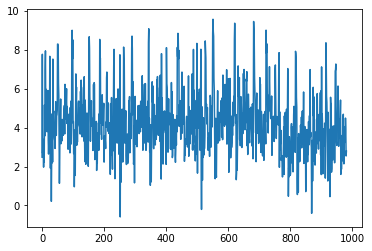

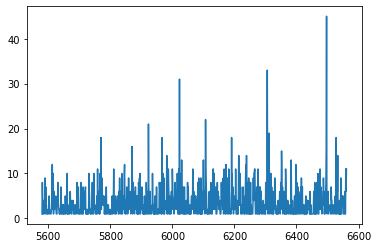

In [374]:
plt.figure()
plt.plot(y_predicted)
plt.figure()
plt.plot(y_test)

In [375]:
br=GradientBoostingRegressor(**{'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 40})

br.fit(X_train,y_train)

br.predict(X_test)


array([ 3.74576948,  7.91843989,  4.5558589 ,  4.9927233 ,  5.32255171,
        4.75562939,  3.34276241,  2.44499006,  4.95008722,  5.28424512,
        5.19731763,  6.10013334,  5.26558653,  5.58431323,  5.57178416,
        6.01019344,  4.79264108,  2.91072678,  5.06156473,  5.06728511,
        2.32833471,  2.68688212,  5.26190433,  5.14401388,  4.82439039,
        5.65582261,  5.73971807,  4.83342701,  5.60476713,  3.45425807,
        3.97532311,  4.17707979,  6.4141638 ,  6.42604757,  4.63061821,
        8.11492751,  7.65363653,  5.21248584,  3.7187472 ,  4.98559352,
        4.68743578,  4.47424363,  4.47424363,  4.91471134,  6.07196887,
        5.24050925,  4.78103366,  4.88346135,  2.99635793,  5.2899655 ,
        7.42139028,  8.56519262, 11.10753367,  5.24703223,  5.31488016,
        5.05250596,  2.62355159,  5.47980164,  3.19177002,  3.07825424,
        5.1718073 ,  5.15981396,  6.2648574 ,  4.14359327,  4.27496616,
        4.50417891,  4.6978713 ,  4.27496616,  3.50761586,  4.67

In [376]:
mse(y_test,br.predict(X_test))

12.254819270042018

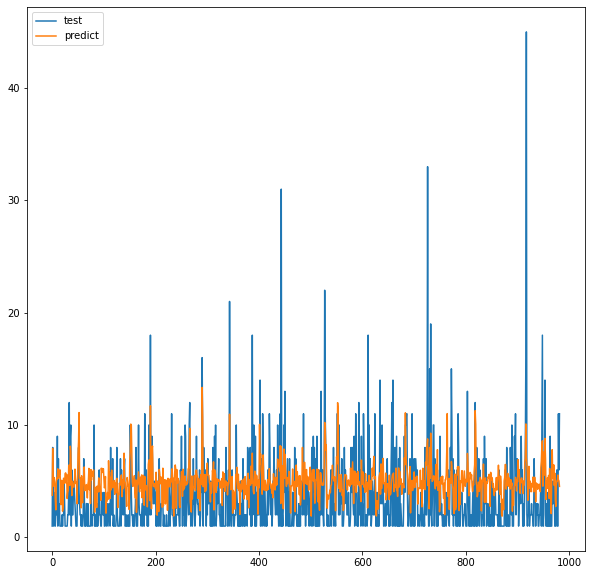

In [377]:
plt.figure(figsize=(10,10))
plt.plot(range(len(br.predict(X_test))),y_test,label='test')
plt.plot(range(len(br.predict(X_test))),br.predict(X_test),label='predict')
plt.legend()

12.660043425172173

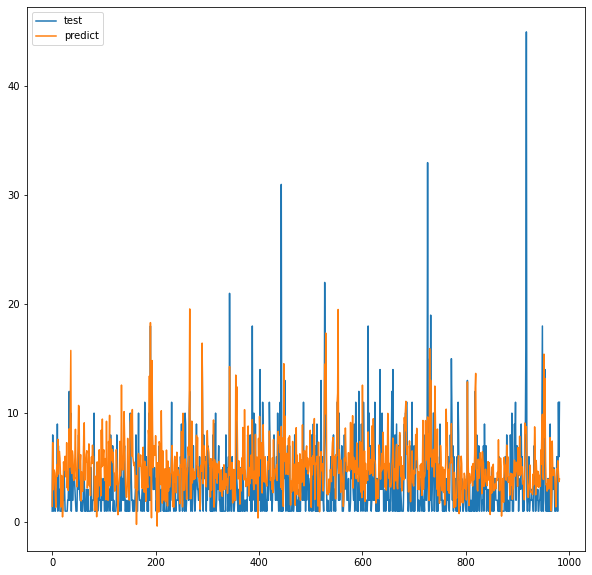

In [378]:
grid_br_mse = GridSearchCV(GradientBoostingRegressor(), param_grid = param_dist,cv=3,n_jobs=4,scoring='neg_mean_squared_error')
grid_br_mse.fit(X_train, y_train)


plt.figure(figsize=(10,10))
plt.plot(range(len(br.predict(X_test))),y_test,label='test')
plt.plot(range(len(br.predict(X_test))),grid_br_mse.predict(X_test),label='predict')
plt.legend()

mse(grid_br_mse.predict(X_test),y_test)

ahora con lag

In [304]:
sales_cat_lag=sales_cat.copy()


In [305]:
for i in range(12):
    sales_cat_lag['CANTIDAD_{}'.format(i+1)]=sales_cat.groupby(['COLOR_POS','CATEGORIA','SUBCATEGORIA_POS','MATERIAL_POS','ESTILO','ACABADO'])[['CANTIDAD']].shift(i+1)

In [306]:
sales_cat_lag=sales_cat_lag.dropna()
sales_cat_lag=sales_cat_lag.reset_index(drop=True)


<AxesSubplot:>

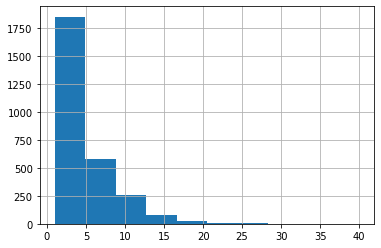

In [307]:
sales_cat_lag['CANTIDAD'].hist()

In [257]:
sales_cat_lag[sales_cat_lag['CANTIDAD']>45]['SUBCATEGORIA_POS'].value_counts()

Series([], Name: SUBCATEGORIA_POS, dtype: int64)

In [280]:
sales_cat_lag.head(5)

,ANIO,MES,COLOR_POS,CATEGORIA,SUBCATEGORIA_POS,MATERIAL_POS,ESTILO,ACABADO,PUESTOS,VIGENCIA,ORIGEN,PRECIO,SUBTOTAL,DESCUENTO(%),TOTAL,CANTIDAD,ALTO,AREA,Factor covid,CANTIDAD_1,CANTIDAD_2,CANTIDAD_3,CANTIDAD_4,CANTIDAD_5,CANTIDAD_6,CANTIDAD_7,CANTIDAD_8,CANTIDAD_9,CANTIDAD_10,CANTIDAD_11,CANTIDAD_12
0,2019,3,NEGRO,COMEDORES,OTROS,VIDRIO,MODERNO,BRILLANTE,4.0,LINEA,IMPORTADO,446685.0,1340055,0.550001,603024,3,120.0,3500.0,0,10.0,9.0,1.0,1.0,1.0,2.0,5.0,15.0,2.0,1.0,2.0,4.0
1,2019,3,NEGRO,COMEDORES,OTROS,VIDRIO,MODERNO,BRILLANTE,6.0,DESCONTINUADO,IMPORTADO,582278.0,5822780,0.470001,3086066,10,75.0,17000.0,0,3.0,10.0,9.0,1.0,1.0,1.0,2.0,5.0,15.0,2.0,1.0,2.0
2,2019,3,NEGRO,COMEDORES,OTROS,VIDRIO,MODERNO,BRILLANTE,6.0,LINEA,IMPORTADO,890858.0,890858,0.500000,445429,1,76.0,11600.0,0,10.0,3.0,10.0,9.0,1.0,1.0,1.0,2.0,5.0,15.0,2.0,1.0
3,2019,4,NEGRO,COMEDORES,OTROS,VIDRIO,MODERNO,BRILLANTE,0.0,DESCONTINUADO,IMPORTADO,621486.0,1242972,0.350000,807932,2,79.0,6000.0,0,1.0,10.0,3.0,10.0,9.0,1.0,1.0,1.0,2.0,5.0,15.0,2.0
4,2019,4,NEGRO,COMEDORES,OTROS,VIDRIO,MODERNO,BRILLANTE,0.0,LINEA,IMPORTADO,320000.0,1920000,0.750000,480000,6,80.0,2400.0,0,2.0,1.0,10.0,3.0,10.0,9.0,1.0,1.0,1.0,2.0,5.0,15.0


<AxesSubplot:>

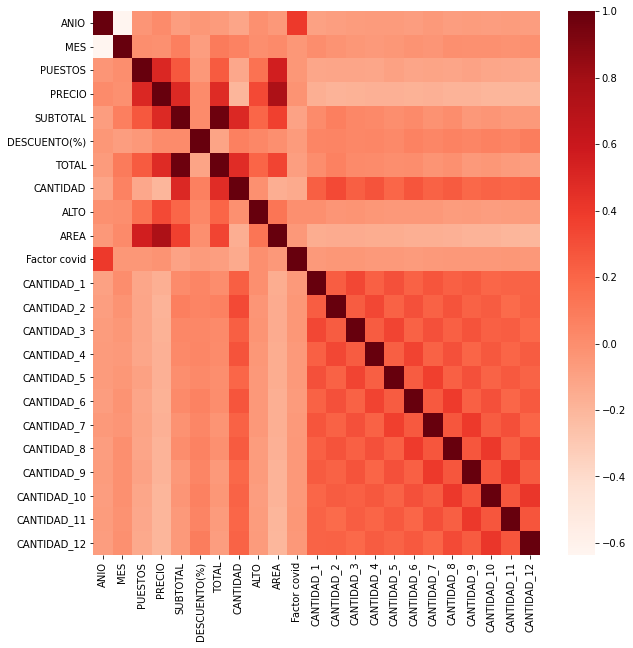

In [117]:
plt.figure(figsize=(10,10))
sns.heatmap(sales_cat_lag.corr(),cmap='Reds')

In [359]:
num_var=['AREA','ALTO','DESCUENTO(%)','PRECIO']
for i in range(1,13):
    num_var.append('CANTIDAD_{}'.format(i))
num_var.append('CANTIDAD')
cat_var=['MES','Factor covid','PUESTOS','COLOR_POS','CATEGORIA','SUBCATEGORIA_POS','VIGENCIA','ORIGEN','ESTILO','MATERIAL_POS','ACABADO']

y=sales_cat_lag['CANTIDAD']

X_num=sales_cat_lag[num_var[:-1]].astype('float')
X_cat=sales_cat_lag[cat_var].astype('category')

X_cat_dummies=pd.get_dummies(X_cat)

from sklearn.preprocessing import MinMaxScaler

scaler=MinMaxScaler()
X_num_norm= scaler.fit_transform(X_num)


X=np.append(X_num_norm,X_cat_dummies,axis=1)

#split data till month 4 from 2021
index=sales_cat_lag[(sales_cat_lag.ANIO==2021) & (sales_cat_lag.MES==1)].head(1).index.values[0]
X_train=X[:index-1]
y_train=(y[:index-1])
X_test=X[index:]
y_test=(y[index:])


import statsmodels.api as sm
from sklearn.metrics import mean_squared_error as mse

mod = sm.OLS(y_train, sm.add_constant(X_train))
res = mod.fit()
res.summary()




<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               CANTIDAD   R-squared:                       0.272
Model:                            OLS   Adj. R-squared:                  0.244
Method:                 Least Squares   F-statistic:                     9.739
Date:                Sat, 28 Aug 2021   Prob (F-statistic):           1.97e-92
Time:                        06:56:10   Log-Likelihood:                -5721.0
No. Observations:                2109   AIC:                         1.160e+04
Df Residuals:                    2030   BIC:                         1.205e+04
Df Model:                          78                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.2263      0.390      3.144      0.002       0.461       1.991
x1            -0.8574      1.329     -0.645      0.519      -3.463       1.748
x2            -0.5292      1.268     -0.417      0.676      -3.016       1.957
x3             0.3470      0.547      0.634      0.526      -0.726       1.420
x4            -4.2701      1.265     -3.375      0.001      -6.752      -1.789
x5             1.0185      0.841      1.211      0.226      -0.631       2.668
x6             7.0699      0.830      8.521      0.000       5.443       8.697
x7             2.4312      0.850      2.861      0.004       0.765       4.098
x8             3.6753      0.843      4.361      0.000       2.022       5.328
x9            -0.6770      0.851     -0.796      0.426      -2.345       0.991
x10            0.5700      0.837      0.681      0.496      -1.072       2.212
x11            0.5604      0.840      0.667      0.505      -1.087       2.207
x12            2.0567      0.842      2.443      0.015       0.406       3.708
x13           -0.4862      0.833     -0.584      0.560      -2.120       1.148
x14            0.1453      0.845      0.172      0.863      -1.511       1.802
x15            1.9150      0.821      2.332      0.020       0.305       3.525
x16            0.7810      0.819      0.953      0.341      -0.826       2.388
x17            0.4123      0.418      0.987      0.324      -0.407       1.231
x18            1.0885      0.412      2.643      0.008       0.281       1.896
x19            0.3276      1.207      0.271      0.786      -2.040       2.695
x20           -1.3418      1.162     -1.155      0.248      -3.620       0.936
x21           -1.1199      0.554     -2.023      0.043      -2.206      -0.034
x22           -0.2751      0.410     -0.671      0.502      -1.079       0.529
x23            0.1509      0.384      0.393      0.694      -0.602       0.903
x24           -0.1847      0.391     -0.473      0.637      -0.951       0.582
x25            0.2006      0.386      0.520      0.603      -0.557       0.958
x26            0.4642      0.342      1.357      0.175      -0.206       1.135
x27            0.6195      0.335      1.849      0.065      -0.038       1.277
x28            0.8841      0.362      2.444      0.015       0.175       1.593
x29            0.9335      0.381      2.450      0.014       0.186       1.681
x30            0.5387      0.420      1.283      0.200      -0.285       1.362
x31            0.2186      0.428      0.511      0.609      -0.620       1.058
x32           -0.4645      1.079     -0.431      0.667      -2.581       1.651
x33           -1.0179      0.592     -1.720      0.086      -2.179       0.143
x34           -2.3967      1.173     -2.043      0.041      -4.697      -0.096
x35            1.4112      0.477      2.961      0.003       0.476       2.346
x3

In [360]:

y_predicted=res.predict(sm.add_constant(X_test, has_constant='add'))
mse(y_test,y_predicted)


12.155746092782884

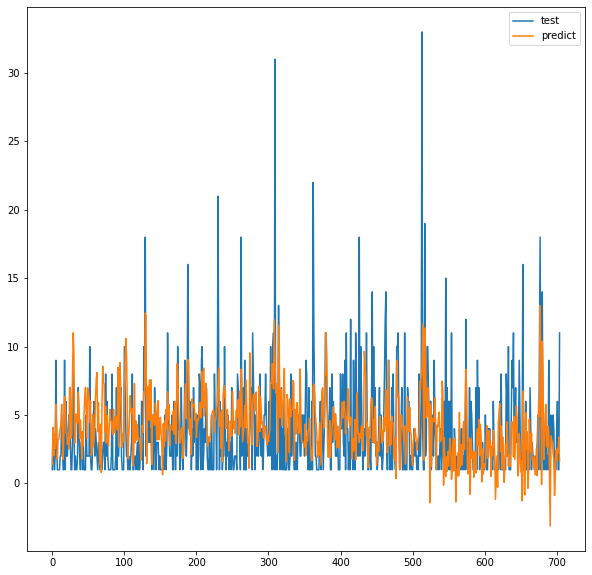

In [361]:
plt.figure(figsize=(10,10))
plt.plot(range(len(res.predict(sm.add_constant(X_test, has_constant='add')))),y_test,label='test')
plt.plot(range(len(res.predict(sm.add_constant(X_test, has_constant='add')))),res.predict(sm.add_constant(X_test, has_constant='add')),label='predict')
plt.legend()

In [362]:
br=GradientBoostingRegressor(**{'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 80})

br.fit(X_train,y_train)



GradientBoostingRegressor(max_depth=6, n_estimators=80)

In [363]:
mse(y_test,br.predict(X_test))

11.79380502465334

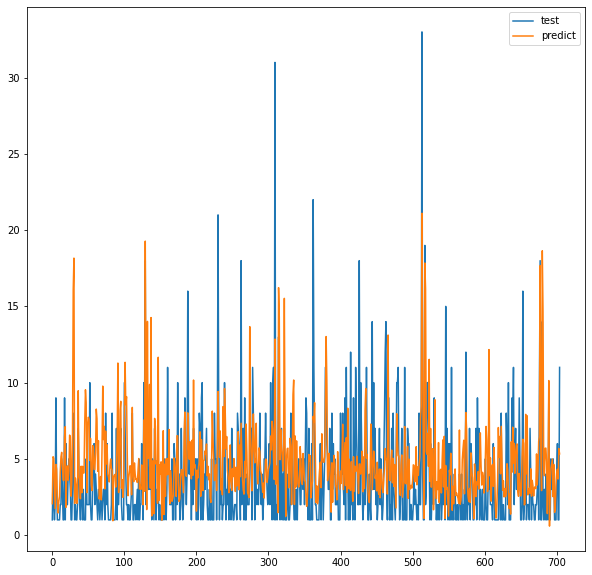

In [364]:
plt.figure(figsize=(10,10))
plt.plot(range(len(br.predict(X_test))),y_test,label='test')
plt.plot(range(len(br.predict(X_test))),br.predict(X_test),label='predict')
plt.legend()

In [365]:
br.predict(X_test).sum()

3344.130082445761

In [366]:
y_test.sum()

2638

In [367]:
r2(br.predict(X_test),y_test)

-0.707759983612757

In [368]:
grid_br_mape = GridSearchCV(GradientBoostingRegressor(), param_grid = param_dist,cv=3,n_jobs=4,scoring='neg_mean_absolute_percentage_error')
grid_br_mape.fit(X_train, y_train)


GridSearchCV(cv=3, estimator=GradientBoostingRegressor(), n_jobs=4,
             param_grid={'learning_rate': [0.01, 0.05, 0.1, 0.3, 0.4, 1],
                         'max_depth': [2, 4, 6, 8, 10],
                         'n_estimators': [30, 40, 100, 200, 300]},
             scoring='neg_mean_absolute_percentage_error')

0.5548367897662179

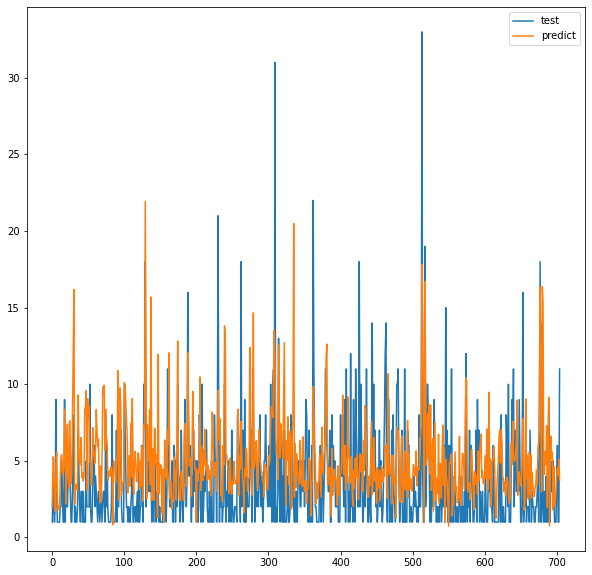

In [369]:

plt.figure(figsize=(10,10))
plt.plot(range(len(br.predict(X_test))),y_test,label='test')
plt.plot(range(len(br.predict(X_test))),grid_br_mape.predict(X_test),label='predict')
plt.legend()

mape(grid_br_mape.predict(X_test),y_test)

In [370]:
grid_br_mse = GridSearchCV(GradientBoostingRegressor(), param_grid = param_dist,cv=3,n_jobs=4,scoring='neg_mean_squared_error')
grid_br_mse.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=GradientBoostingRegressor(), n_jobs=4,
             param_grid={'learning_rate': [0.01, 0.05, 0.1, 0.3, 0.4, 1],
                         'max_depth': [2, 4, 6, 8, 10],
                         'n_estimators': [30, 40, 100, 200, 300]},
             scoring='neg_mean_squared_error')

11.810640818082982

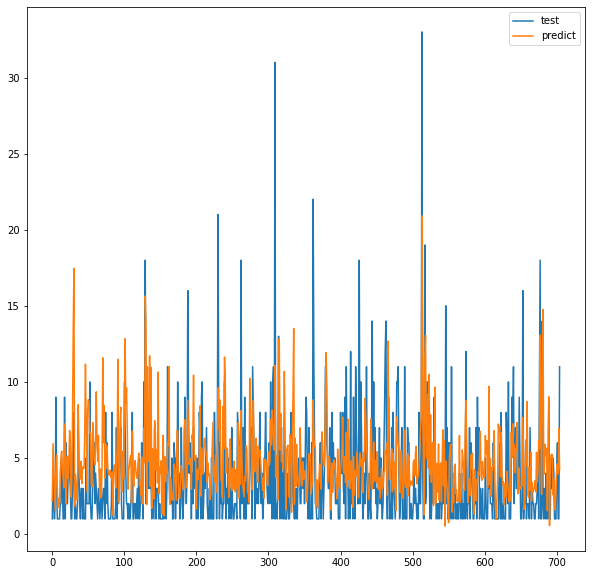

In [371]:

plt.figure(figsize=(10,10))
plt.plot(range(len(br.predict(X_test))),y_test,label='test')
plt.plot(range(len(br.predict(X_test))),grid_br_mse.predict(X_test),label='predict')
plt.legend()

mse(grid_br_mse.predict(X_test),y_test)

una prueba final

In [356]:
sales_ref_month2=sales_ref_month.loc[remove_outlier_IQR(sales_ref_month['CANTIDAD']).index].reset_index(drop=True)

num_var=['AREA','ALTO','DESCUENTO(%)','PRECIO','CANTIDAD',]
cat_var=['MES','Factor covid','PUESTOS','COLOR_POS','CATEGORIA','SUBCATEGORIA_POS','VIGENCIA','ORIGEN','ESTILO','MATERIAL_POS','ACABADO']

y=sales_ref_month2['CANTIDAD']

X_num=sales_ref_month2[num_var[:-1]].astype('float')
X_cat=sales_ref_month2[cat_var].astype('category')

X_cat_dummies=pd.get_dummies(X_cat)

from sklearn.preprocessing import MinMaxScaler, StandardScaler

scaler=MinMaxScaler()
X_num_norm= scaler.fit_transform(X_num)


X=np.append(X_num_norm,X_cat_dummies,axis=1)

#split data till januar 2021
index=sales_ref_month2[(sales_ref_month2.ANIO==2021)].index[0]
X_train=X[:index-1]
y_train=y[:index-1]
X_test=X[index:]
y_test=y[index:]


import statsmodels.api as sm
from sklearn.metrics import mean_squared_error as mse

mod = sm.OLS(y_train, sm.add_constant(X_train))
res = mod.fit()
res.summary()

y_predicted=res.predict(sm.add_constant(X_test,has_constant='add'))
mse(y_test,y_predicted)

5.340087460794836

In [357]:
test=sales_ref_month2.loc[index:]
test['predicted']=y_predicted
pf=test.groupby(['ANIO','MES','COLOR_POS','CATEGORIA','SUBCATEGORIA_POS','MATERIAL_POS','ESTILO','ACABADO','PUESTOS','VIGENCIA','ORIGEN']).agg({'CANTIDAD':'sum','predicted':'sum'}).reset_index()

In [358]:
mse(pf.CANTIDAD,pf.predicted)

8.0090090467245

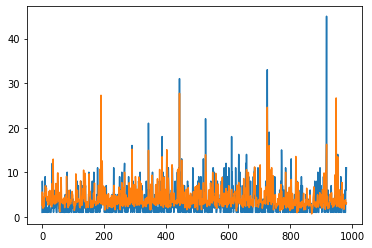

In [355]:
plt.plot(pf.CANTIDAD)
plt.plot(pf.predicted)

In [351]:
sales_cat=sales_ref_month2.groupby(['ANIO','MES','COLOR_POS','CATEGORIA','SUBCATEGORIA_POS','MATERIAL_POS','ESTILO','ACABADO','PUESTOS','VIGENCIA','ORIGEN']).agg({'PRECIO':'mean','SUBTOTAL':'sum','DESCUENTO(%)':'mean','TOTAL':'sum','CANTIDAD':'sum','ALTO':'mean','AREA':'mean','Factor covid':'first'}).reset_index()


num_var=['AREA','ALTO','DESCUENTO(%)','PRECIO','CANTIDAD',]
cat_var=['MES','Factor covid','PUESTOS','COLOR_POS','CATEGORIA','SUBCATEGORIA_POS','VIGENCIA','ORIGEN','ESTILO','MATERIAL_POS','ACABADO']

y=sales_cat['CANTIDAD']

X_num=sales_cat[num_var[:-1]].astype('float')
X_cat=sales_cat[cat_var].astype('category')

X_cat_dummies=pd.get_dummies(X_cat)

from sklearn.preprocessing import MinMaxScaler

scaler=MinMaxScaler()
X_num_norm= scaler.fit_transform(X_num)


X=np.append(X_num_norm,X_cat_dummies,axis=1)

#split data till januar 2021
index=sales_cat[(sales_cat.ANIO==2021)].index[0]
X_train=X[:index-1]
y_train=y[:index-1]
X_test=X[index:]
y_test=y[index:]


import statsmodels.api as sm
from sklearn.metrics import mean_squared_error as mse

mod = sm.OLS(y_train, sm.add_constant(X_train))
res = mod.fit()
res.summary()




X_test

y_predicted=res.predict(sm.add_constant(X_test))
mse(y_test,y_predicted)


13.703832067169872

In [ ]:
plt.plot(pf.CANTIDAD)
plt.plot(pf.predicted)

In [352]:
sales_cat[index:]==

,ANIO,MES,COLOR_POS,CATEGORIA,SUBCATEGORIA_POS,MATERIAL_POS,ESTILO,ACABADO,PUESTOS,VIGENCIA,ORIGEN,PRECIO,SUBTOTAL,DESCUENTO(%),TOTAL,CANTIDAD,ALTO,AREA,Factor covid
5580,2021,1,AMARILLO,COMEDORES,SET 4P,VIDRIO,CONTEMPORÁNEO,BRILLANTE,4.0,DESCONTINUADO,IMPORTADO,1.113506e+06,1113506,0.550000,501078,1,75.0,10000.0,2
5581,2021,1,AMARILLO,COMEDORES,SILLAS DE COMEDOR,MICROFIBRA,CONTEMPORÁNEO,TEXTILES SUAVES,1.0,NOVEDAD,IMPORTADO,2.685821e+05,2153255,0.519563,1007866,8,77.0,1880.0,2
5582,2021,1,AMARILLO,SALAS Y SOFAS,PUFF,MICROFIBRA,MODERNO,TEXTILES SUAVES,1.0,LINEA,MANUFACTURADO,1.331097e+05,532438,0.666669,166386,4,46.0,1296.0,2
5583,2021,1,AMARILLO,SALAS Y SOFAS,SILLAS AUXILIARES,OTRO,CONTEMPORÁNEO,TEXTURA SUAVE,1.0,DESCONTINUADO,IMPORTADO,2.395740e+05,239574,0.599998,95830,1,83.0,2565.0,2
5584,2021,1,AMARILLO,SALAS Y SOFAS,SOFA 2P,MICROFIBRA,CONTEMPORÁNEO,TEXTILES SUAVES,2.0,DESCONTINUADO,MANUFACTURADO,1.222855e+06,4891420,0.532578,2282823,4,85.0,11815.0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6557,2021,4,OTRO,SALAS Y SOFAS,SOFA CAMA ABATIBLE,MICROFIBRA,MODERNO,TEXTILES SUAVES,3.0,LINEA,MANUFACTURADO,6.610620e+05,661062,0.543489,301782,1,82.0,16744.0,1
6558,2021,4,ROJO,SALAS Y SOFAS,POLTRONAS,MICROFIBRA,CONTEMPORÁNEO,TEXTILES SUAVES,1.0,NOVEDAD,IMPORTADO,6.157650e+05,615765,0.390907,375058,1,80.0,3819.0,1
6559,2021,4,ROJO,SALAS Y SOFAS,POLTRONAS,MICROFIBRA,CONTEMPORÁNEO,TEXTILES SUAVES,1.0,NOVEDAD,NACIONAL,5.626908e+05,6152812,0.515910,3173041,11,77.0,4104.0,1
6560,2021,4,ROJO,SALAS Y SOFAS,SOFA 2P,OTRO,CONTEMPORÁNEO,TEXTILES SUAVES,2.0,NOVEDAD,MANUFACTURADO,1.349659e+06,8097952,0.546970,3665683,6,77.0,13833.0,1
